# INM701 Coursework
### Aaron Mir (Student Number: 160001207)

In this coursework, you are expected to demonstrate what you have learned in the module by applying artificial intelligence techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which data processing steps you will need to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as needed, validate your results and communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Classification of Atrial Fibrillation using a 1D Convolutional Neural Network and Random Forest
Goal: Use the Paroxysmal Atrial Fibrillation Prediction Challenge Database to build a model that can predict onset of Atrial Fibrillation (AF) from an Electrocardiogram (ECG) signal. This database contains a training set (with 50 30-minute two-lead ECGs of patients with Normal Sinus Rhythm (NSR/no signs of AF) and 50 30-minute two-lead ECGs of patients with Paroxysmal AF) and a testing set. The labels of the testing set are not known so in order to test the model, the training set will be split into training and testing sets. 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.signal import filtfilt
import itertools
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import keras
import tensorflow.keras.utils
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
import time as t

In [2]:
# Percentage of borrowed code: 3% - confusion matrix plot function taken from Scikit-learn website.
# [1] Sci-kit Learn (2016) Confusion Matrix Plot Function, Available at: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html (Accessed: 01 December 2020).

In [3]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"Tesorflow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
Tesorflow Version: 2.3.0
Keras Version: 2.4.0
Sklearn Version: 0.23.1


## Data Preprocessing and Segmentation

In [4]:
classification = ['NSR', 'AF']
train_folder =  'data/Train'          # data in csv format
numpy_data = 'data/Numpy_Data'        # will contain X_train and y_train data after conversion to np file 

In [5]:
def bandpass_filter(X): # function to filter the signal between 1Hz and 40Hz to 
                        # remove baseline wander, motion artifacts, line frequency, respiratory artifacts etc.
    fs = 128.0
    highpass_cutoff = 1.0
    lowpass_cutoff = 40.0

    nyq = 0.5 *fs
    low = highpass_cutoff / nyq
    high = lowpass_cutoff / nyq
    order = 1

    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    x_bp = scipy.signal.filtfilt(b, a, X, axis=0)
    return x_bp

In [6]:
# Each ECG file has 230400 data points and two-leads so two columns per lead and 
# 100 ECG files in total but we want to segment these in order to feed more easily into the model
def load_label_segment(location, length, filtered): 
    X = []
    y = []
    if length == '1 min':
        splitter = 30
    else: splitter = 6
    for i in classification:                       # iterate through each type of classification
        for data in os.listdir(location + i):
            df = pd.read_csv(location + i + '\\' \
                + data, names=["ECG1", "ECG2"])    # load the CSV for each file per each classification
            split = np.array_split(df, splitter)   # splitting the data into 5 minute lengths to decrease number of convolutions and increase speed 
            for array in split:
                if filtered == True:
                    X.append(np.array(bandpass_filter(array)))
                else: X.append(np.array(array))  # apply the filter to the ECGs
                if i == 'NSR':                   # label data using one-hot
                    y.append(0)
                if i == 'AF':
                    y.append(1)    
    return np.array(X), np.expand_dims(np.array(y), axis=1)    

In [8]:
# Load raw ECG training data - for visual comparison below
X_train_raw, y_train_raw = load_label_segment(train_folder, '5 min', False) 
# '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train_raw.shape, y_train_raw.shape)

(600, 38400, 2) (600, 1)


In [94]:
# Load filtered ECG training data - Use 5 min segments for first CNN model, 1 min for second CNN
X_train, y_train = load_label_segment(train_folder, '5 min', True) 
# '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(600, 38400, 2) (600, 1)


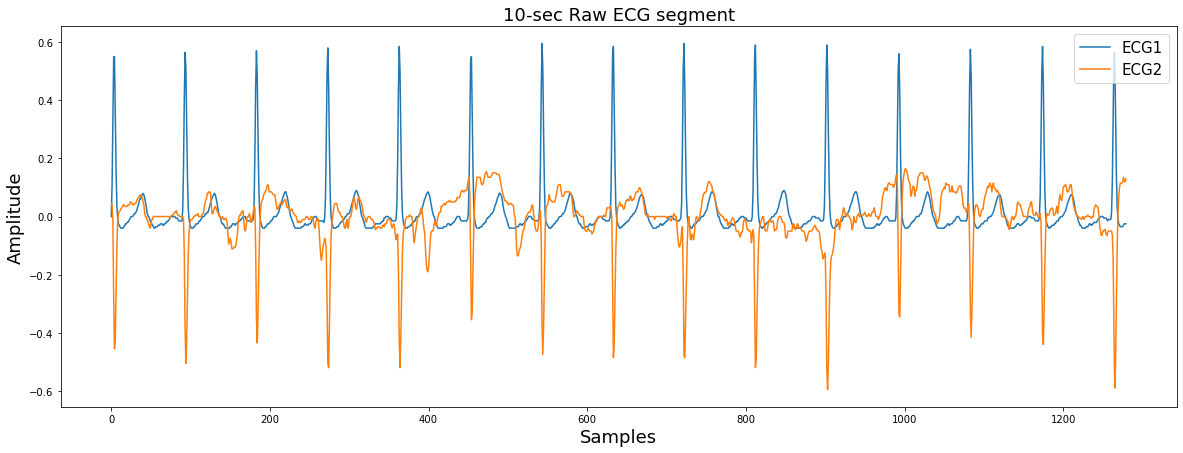

In [88]:
plt.figure(figsize=(20, 7))
plt.plot(X_train_raw[6][1500:2780])  
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec Raw ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper right", prop={'size': 15})
plt.show()

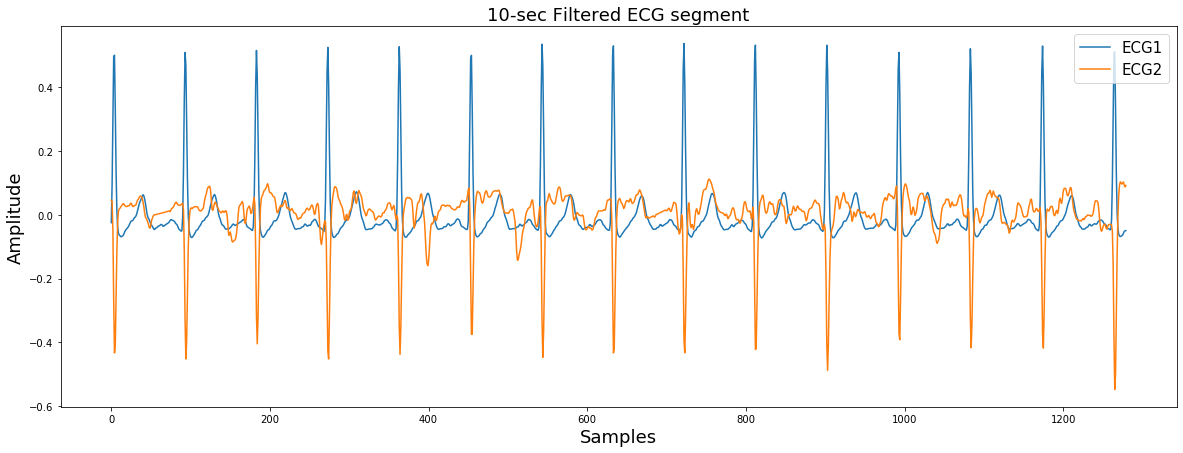

In [95]:
plt.figure(figsize=(20, 7))
plt.plot(X_train[6][1500:2780])
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec Filtered ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper right", prop={'size': 15})
plt.show()

## 1D Convolutional Neural Network Models
### GPU is available for training the model, IT IS RECOMMENDED TO USE GPU FOR THE MODELS
For the evaluation of the models, the data was split into training, testing and validation sets as seen below. In order to decrease our number of convolutions and increase generalisation, the dataset is segmented into either 5 minute length segments or 1 minute length segments. 

In [25]:
device_lib.list_local_devices(); 

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=1)  
#70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
#75/25 train/val split 

In [97]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(315, 38400, 2) (315, 1)
(180, 38400, 2) (180, 1)
(105, 38400, 2) (105, 1)


# Configuration 1 - WORKS WELL - SMALL AND FAST - USES 5 MINUTE ECG SEGMENTS AS INPUT - BASELINE MODEL

In [84]:
# input, convolutional, subsampling(maxpool), fully connected and output
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=32, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(38400, 2))) # Conv layer - 5 minute ECG input 
model.add(MaxPool1D(pool_size=32))                                                                                                       # Subsampling layer
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                               # Dense layer
model.add(MaxPool1D(pool_size=16))                                                                                                       # Subsampling layer
model.add(Flatten())                                                                                                                     # Flatten
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                             # Sigmoid output, better than softmax
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 38400, 128)        8320      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1200, 128)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 1200, 32)          4128      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 75, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2401      
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
__________________________________________________

## Adam works well - Learning rate 0.0001 - Takes very long for loss to even out - Overfitting

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val,y_val), callbacks=[es, es2])

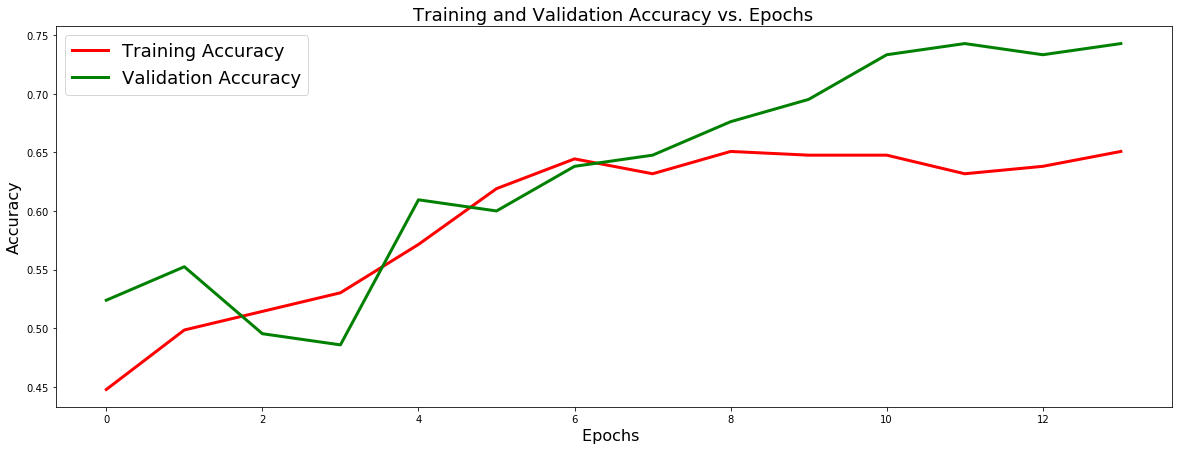

In [38]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

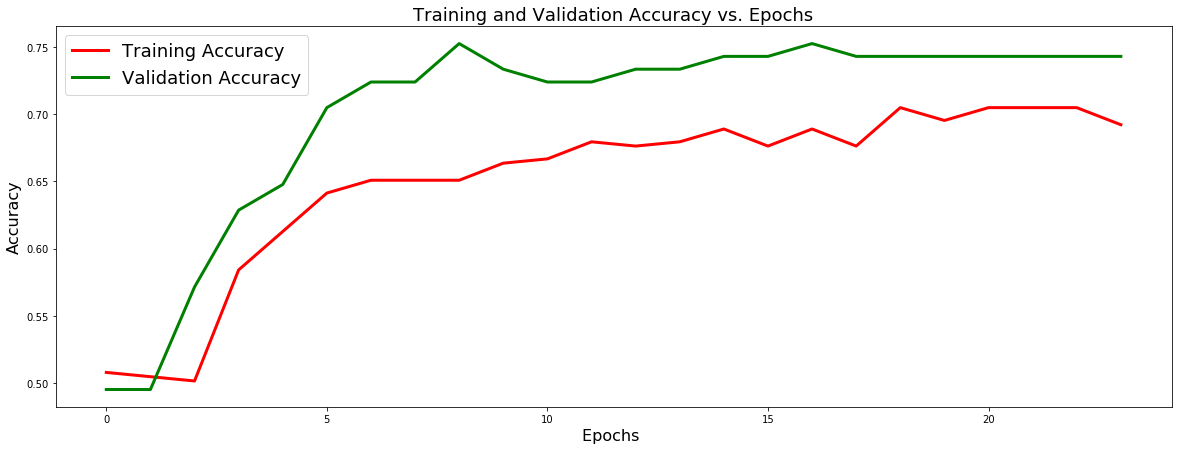

In [26]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

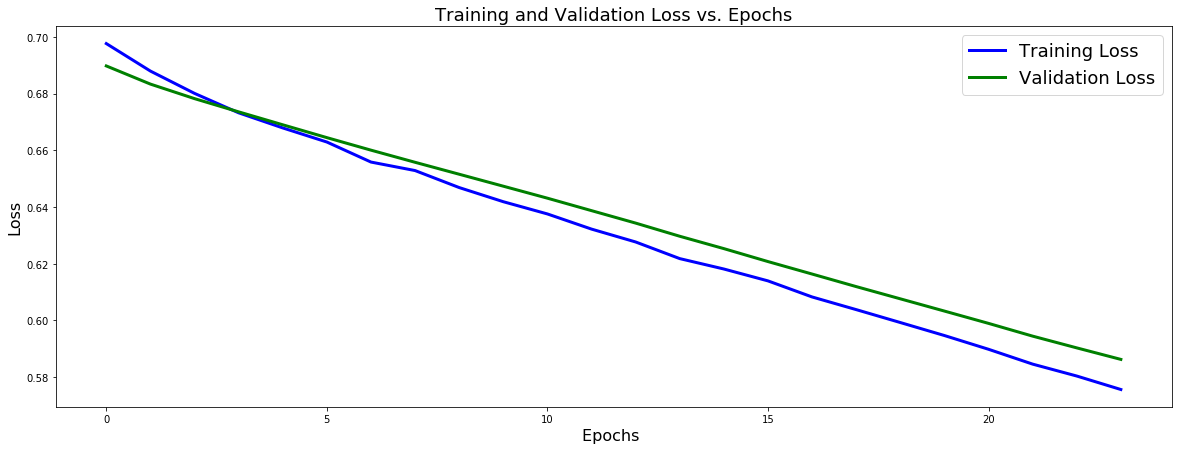

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - Increased learning rate to 0.001 - slight overfitting but still good - Testing many times for verification - similar results throughout

In [85]:
optimizer = keras.optimizers.Adam(lr=0.001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
start = t.time()
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val,y_val), callbacks=[es, es2])
end = t.time()
print('Time taken to run fit: ', end - start, 'seconds')

Epoch 1/40
5/5 [==============================] - 1s 268ms/step - loss: 0.7146 - accuracy: 0.5333 - val_loss: 0.6773 - val_accuracy: 0.5333
Epoch 2/40
5/5 [==============================] - 1s 236ms/step - loss: 0.6714 - accuracy: 0.5746 - val_loss: 0.6366 - val_accuracy: 0.6190
Epoch 3/40
5/5 [==============================] - 1s 236ms/step - loss: 0.6222 - accuracy: 0.6095 - val_loss: 0.6054 - val_accuracy: 0.6000
Epoch 4/40
5/5 [==============================] - 1s 234ms/step - loss: 0.5769 - accuracy: 0.6984 - val_loss: 0.5854 - val_accuracy: 0.6667
Epoch 5/40
5/5 [==============================] - 1s 233ms/step - loss: 0.5509 - accuracy: 0.6762 - val_loss: 0.5485 - val_accuracy: 0.6571
Epoch 6/40
5/5 [==============================] - 1s 234ms/step - loss: 0.5226 - accuracy: 0.7365 - val_loss: 0.5025 - val_accuracy: 0.7619
Epoch 7/40
5/5 [==============================] - 1s 235ms/step - loss: 0.4950 - accuracy: 0.7111 - val_loss: 0.4787 - val_accuracy: 0.7714
Epoch 8/40
5/5 [====

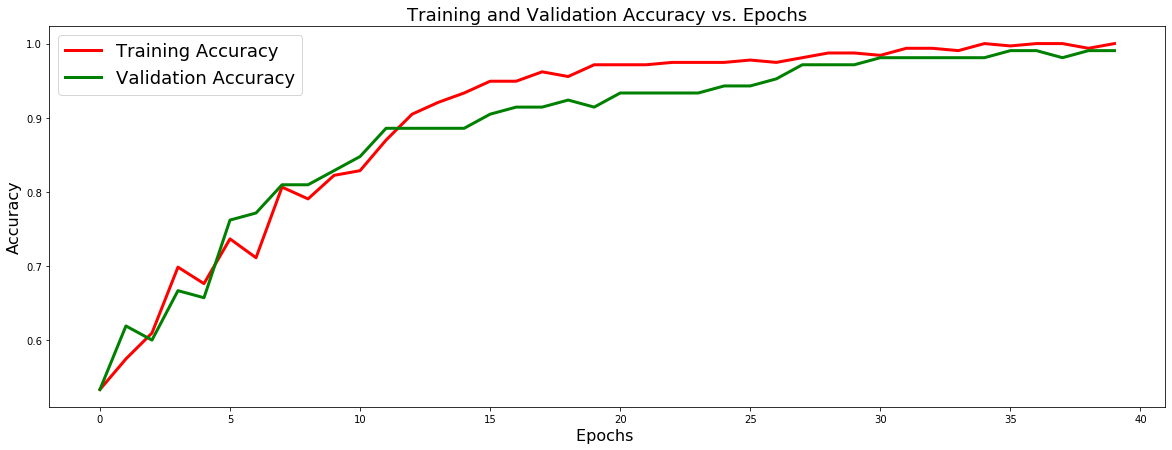

In [86]:
plt.figure(figsize=(20, 7))                                                 # pretty smooth accuracy curve
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

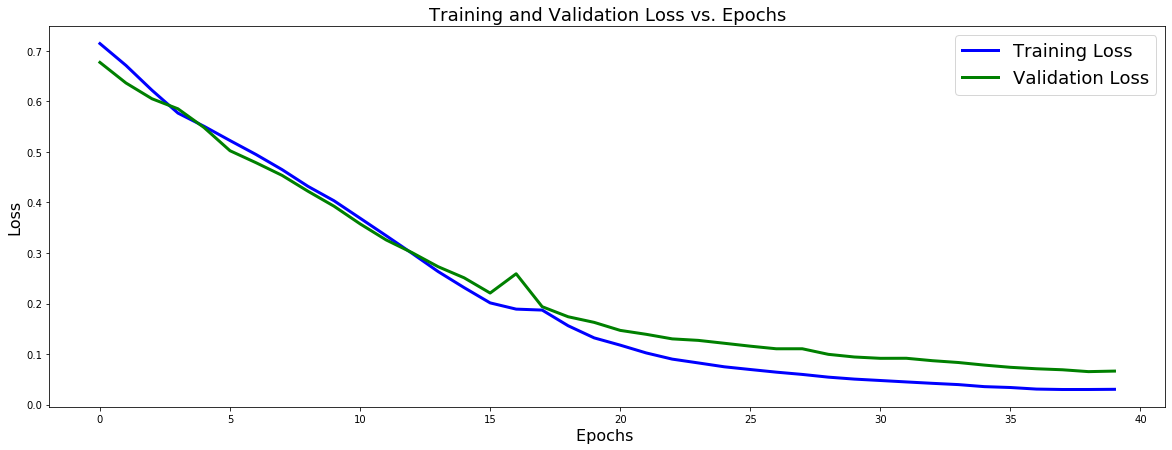

In [87]:
plt.figure(figsize=(20, 7))                                                 # fairly good loss
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

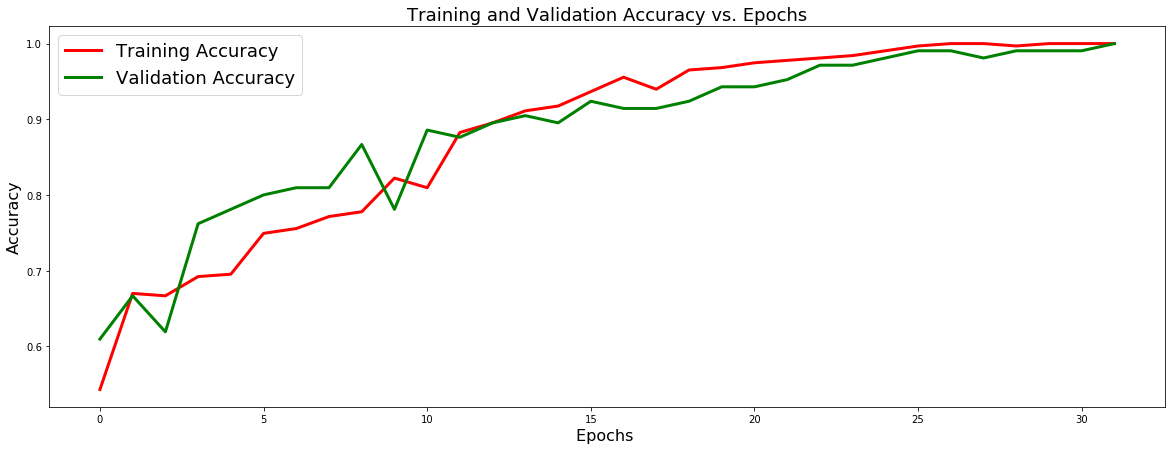

In [44]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

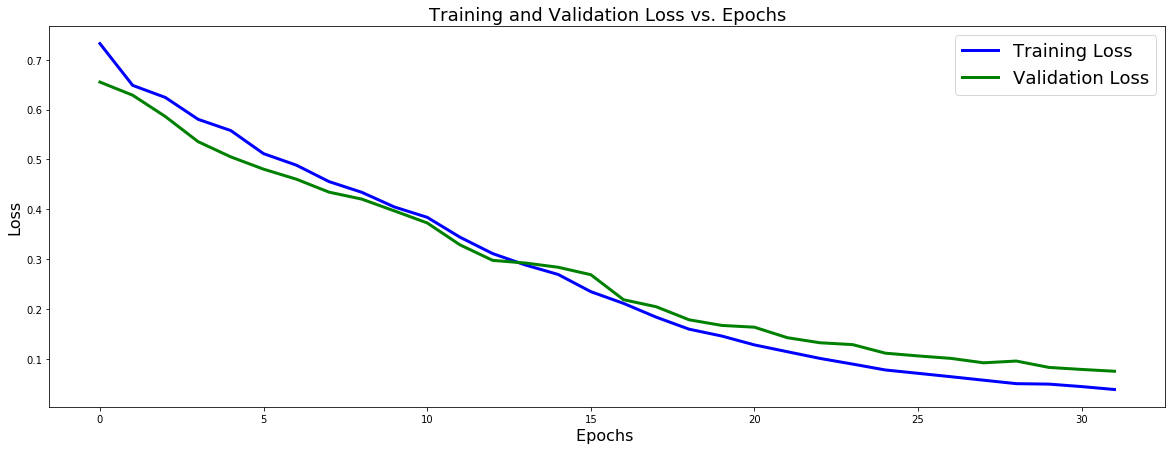

In [45]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

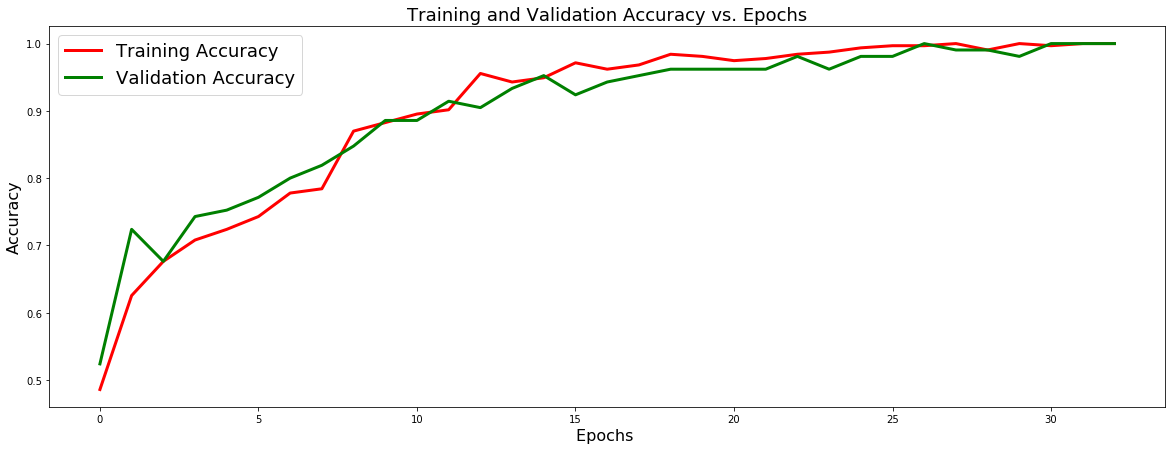

In [65]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

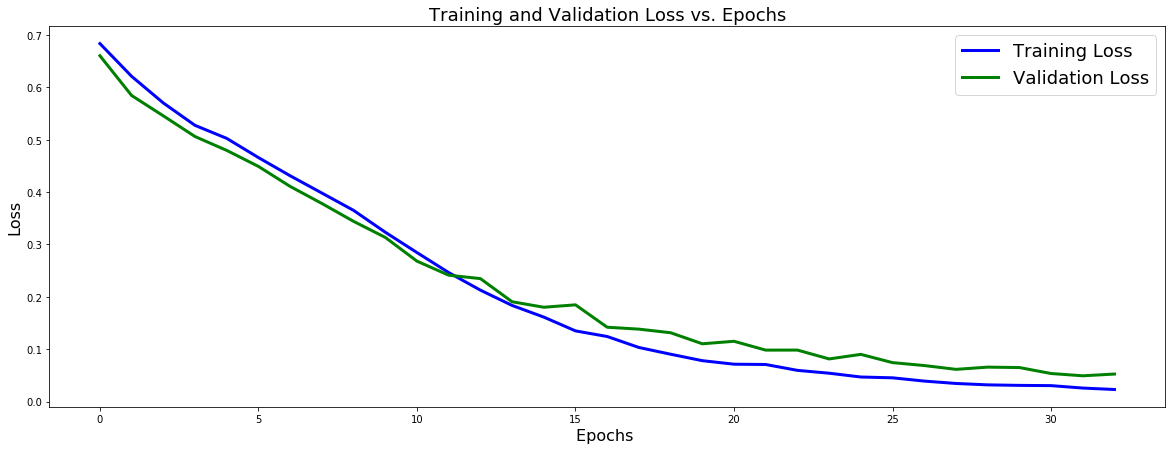

In [66]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

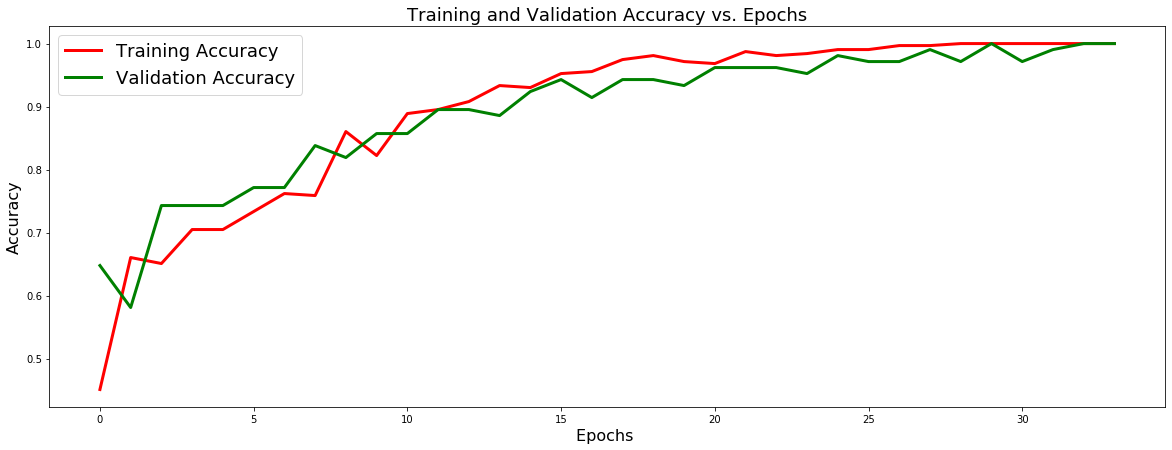

In [57]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

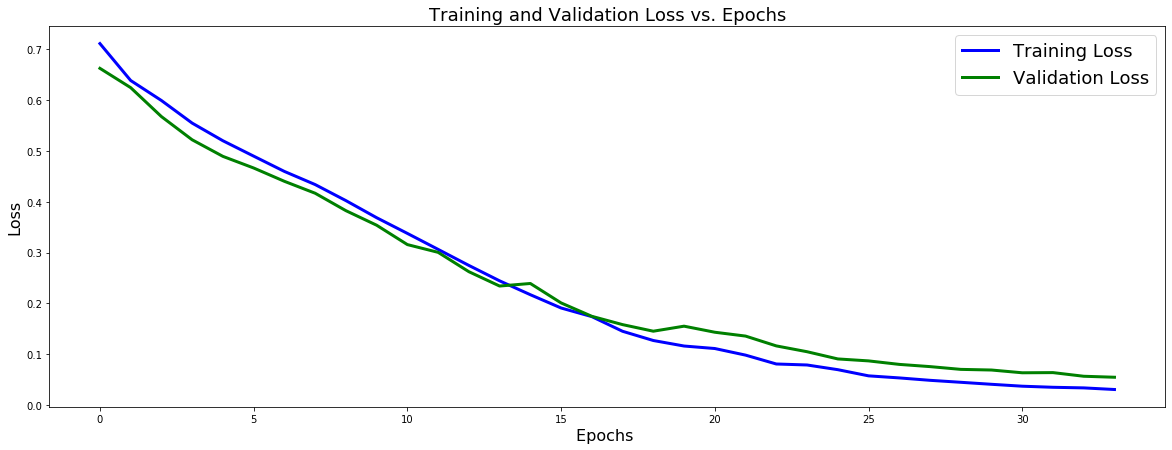

In [58]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

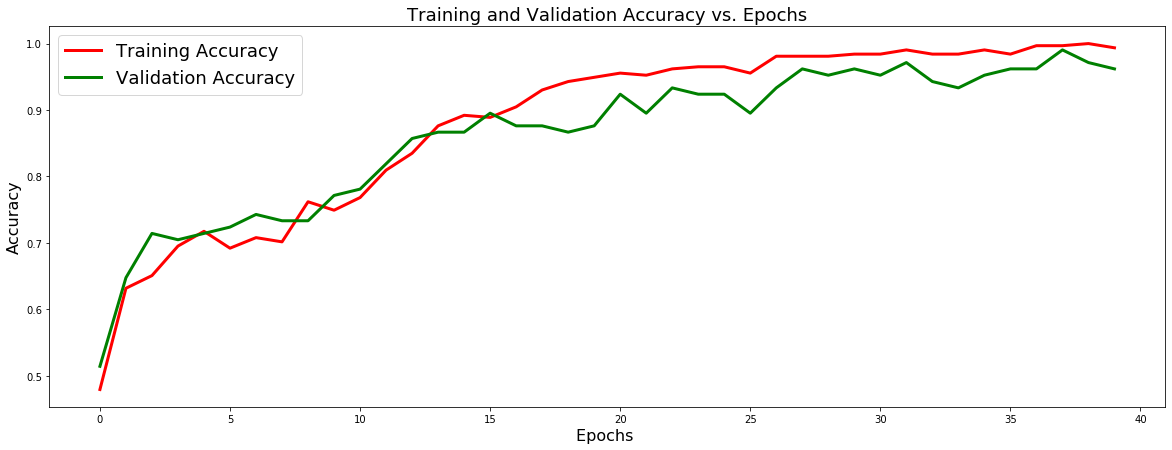

In [87]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

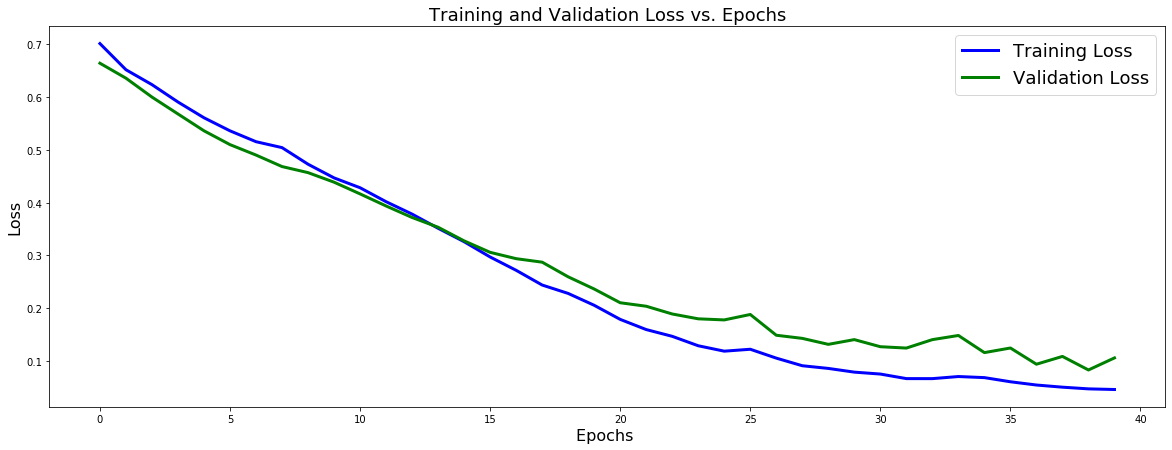

In [88]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

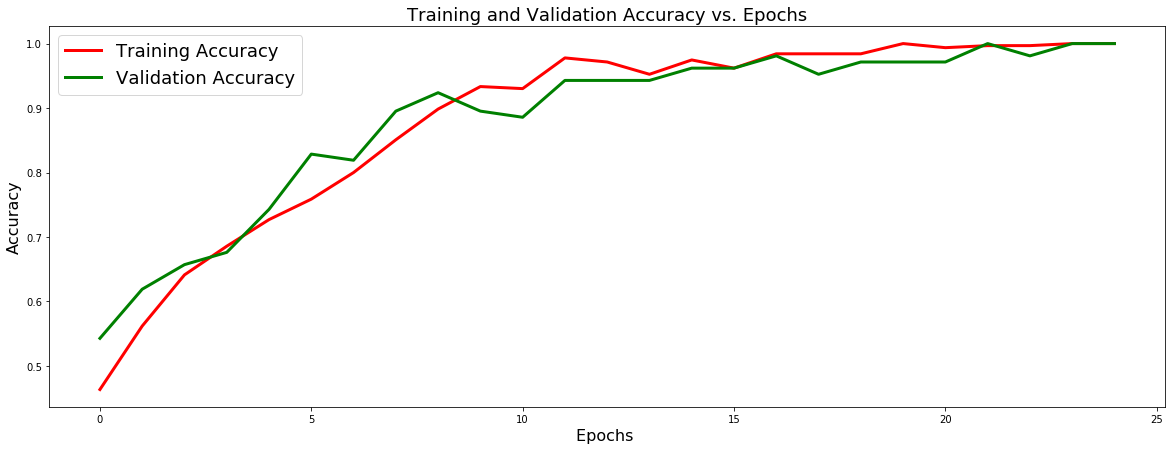

In [22]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

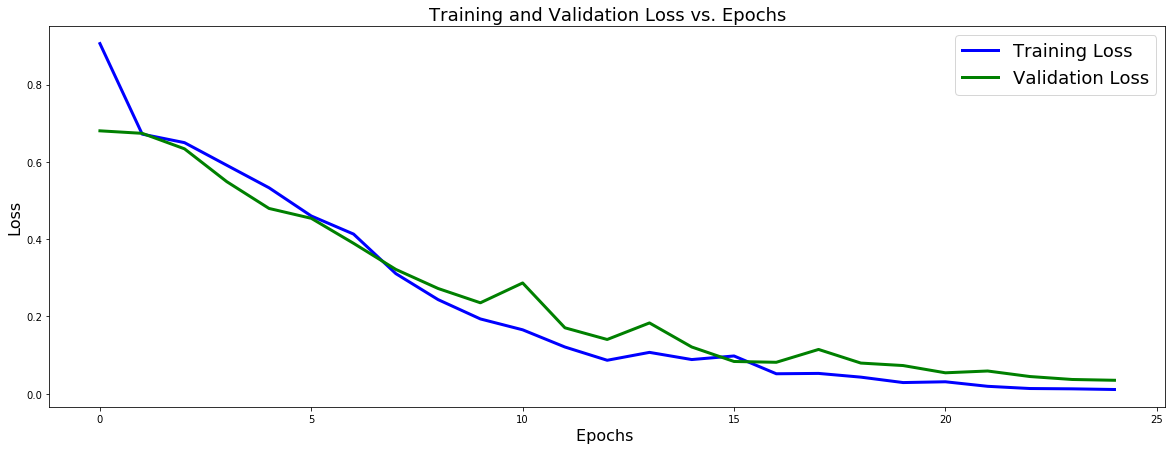

In [23]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

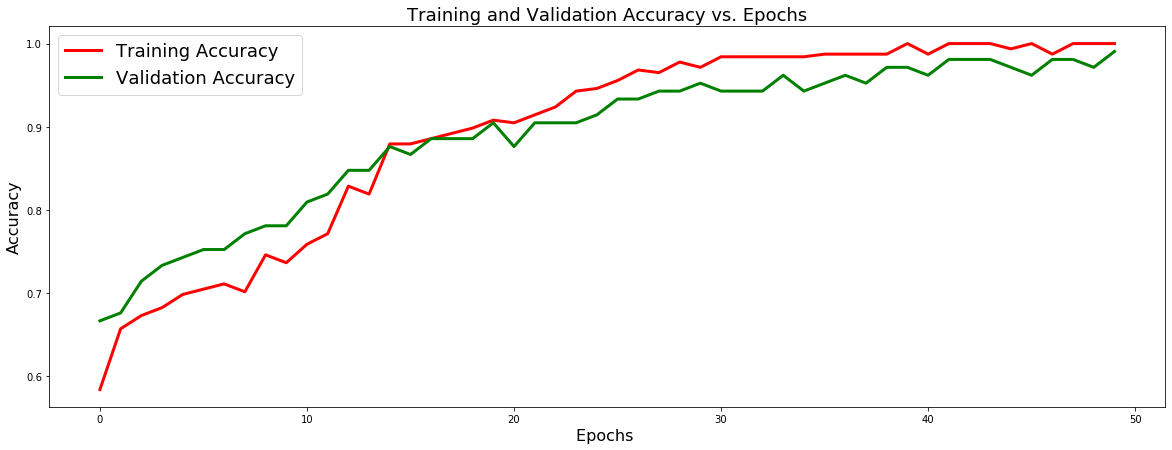

In [55]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

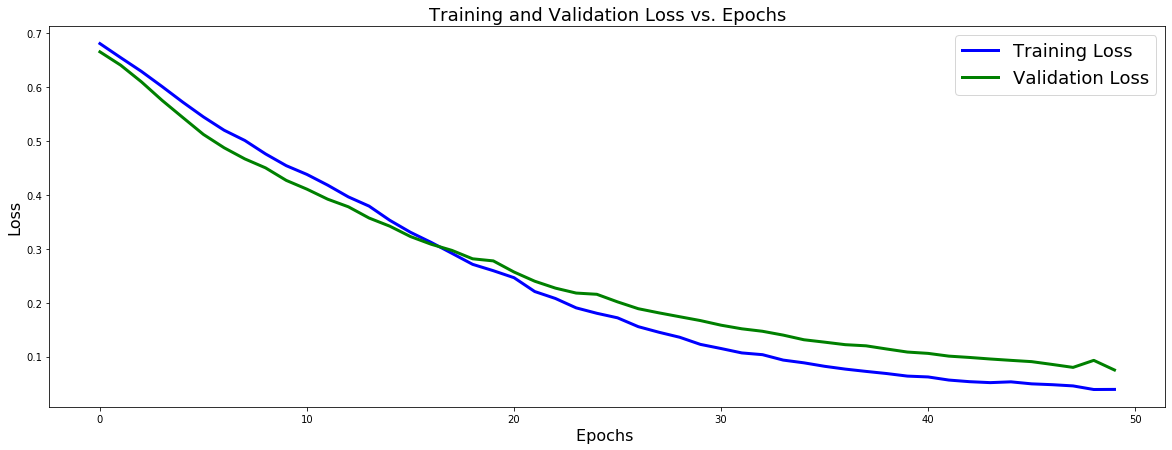

In [56]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

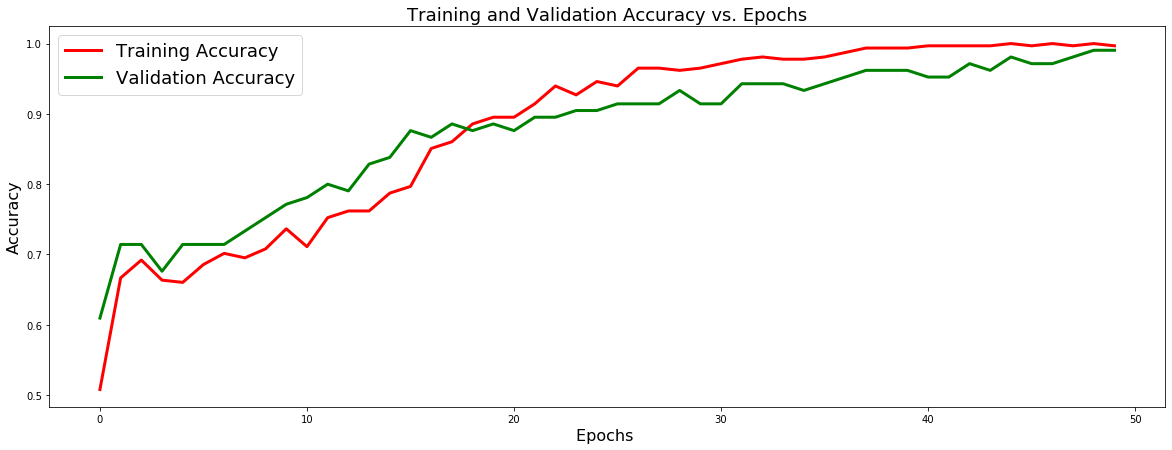

In [86]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

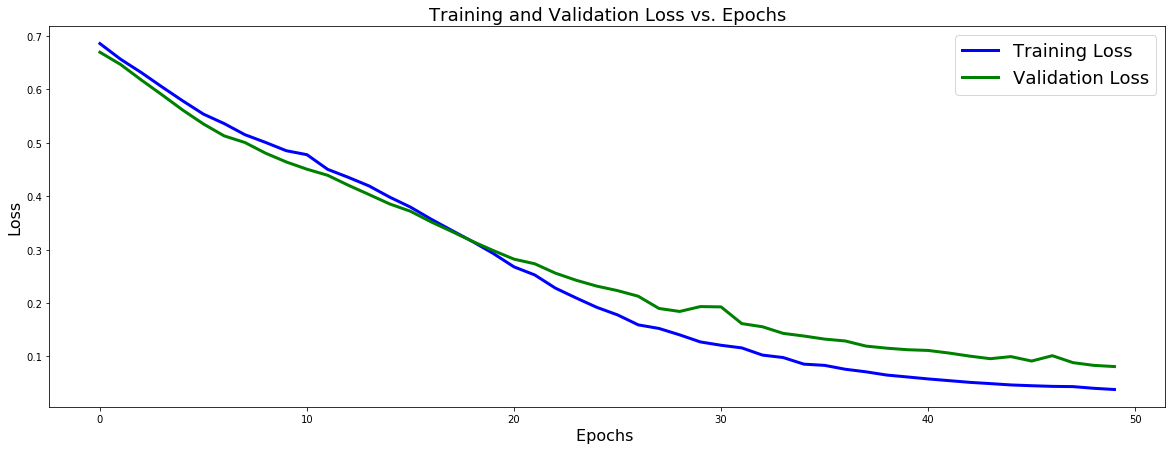

In [87]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - learning rate 0.01 - Not bad 

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val,y_val), callbacks=[es, es2])

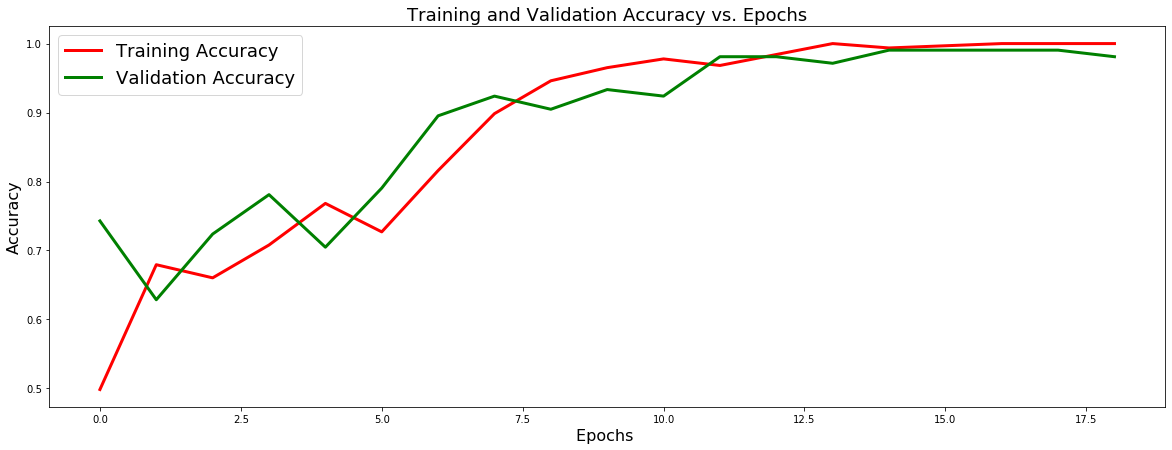

In [93]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

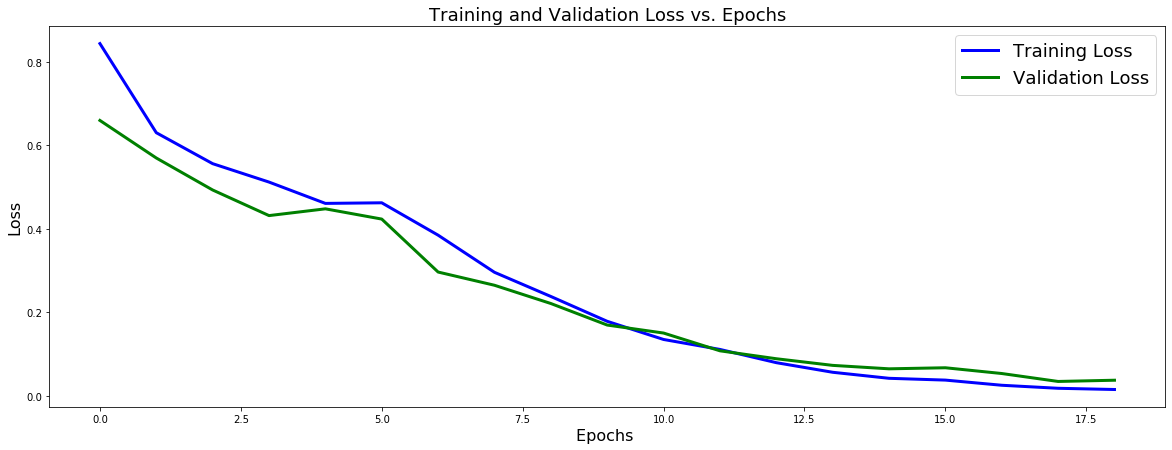

In [94]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

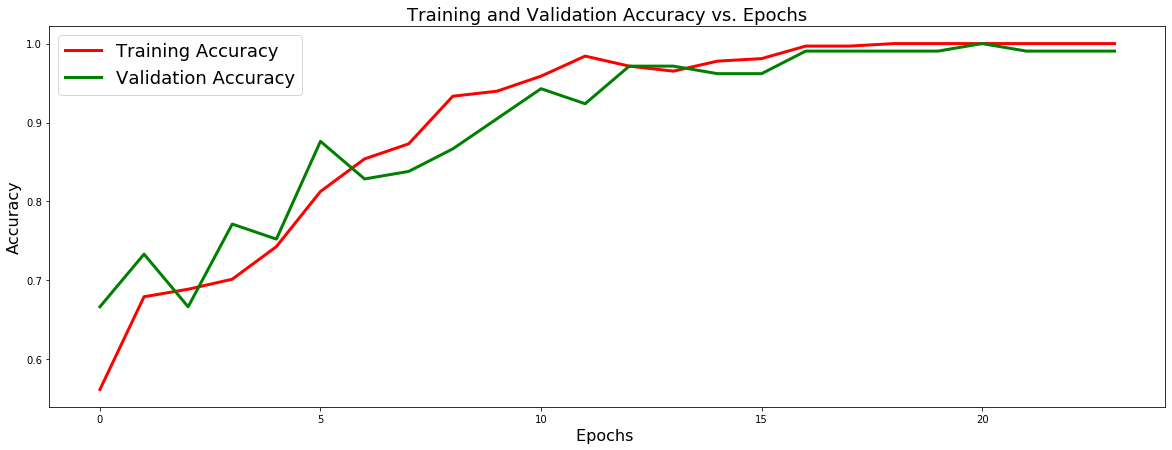

In [51]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

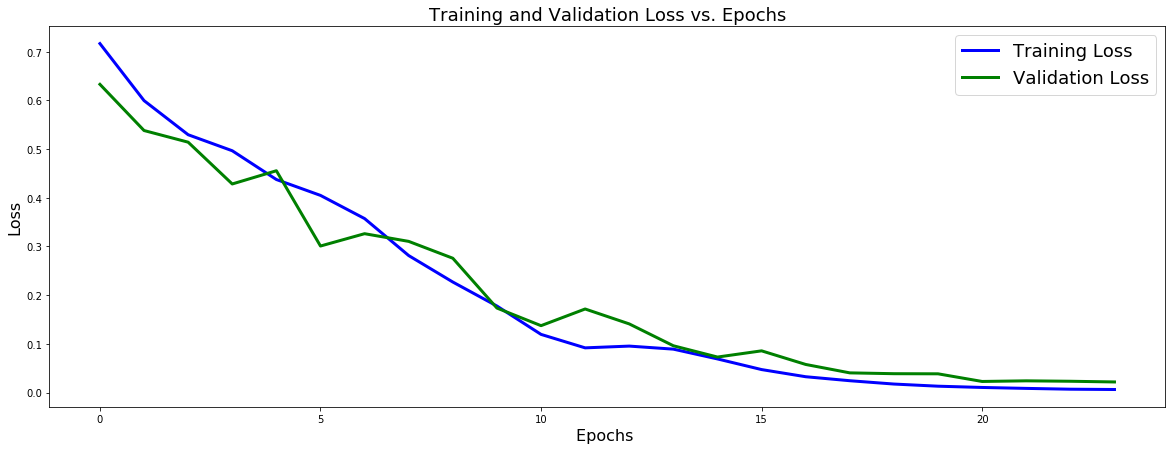

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - learning rate 0.09 - Not good

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.09) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=6)
history = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_val,y_val), callbacks=[es, es2])

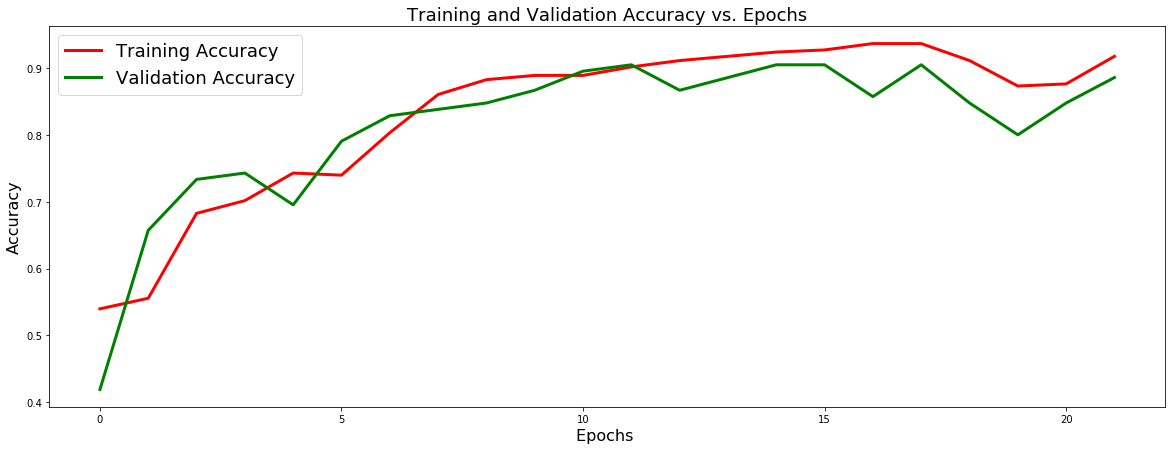

In [133]:
plt.figure(figsize=(20, 7))                                                  
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

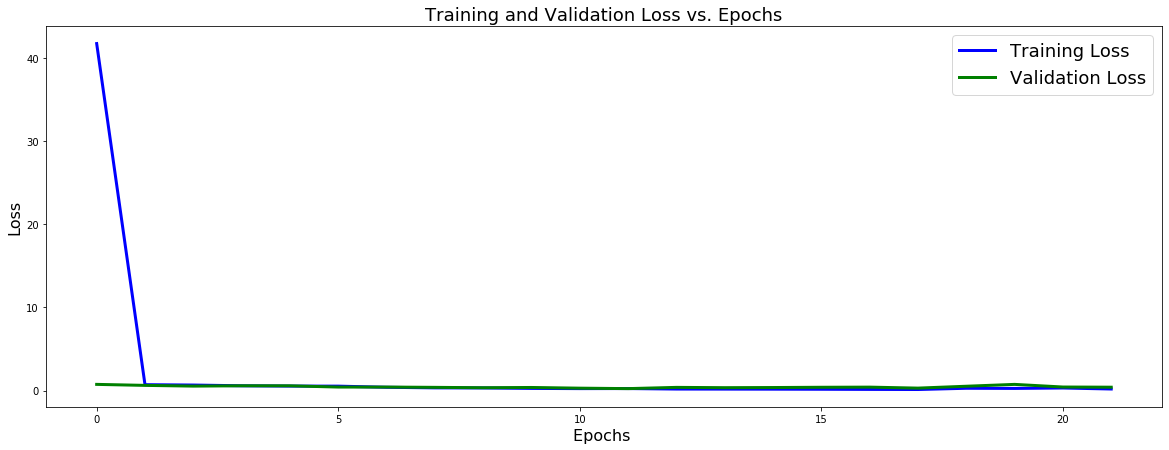

In [134]:
plt.figure(figsize=(20, 7))                                                                     
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

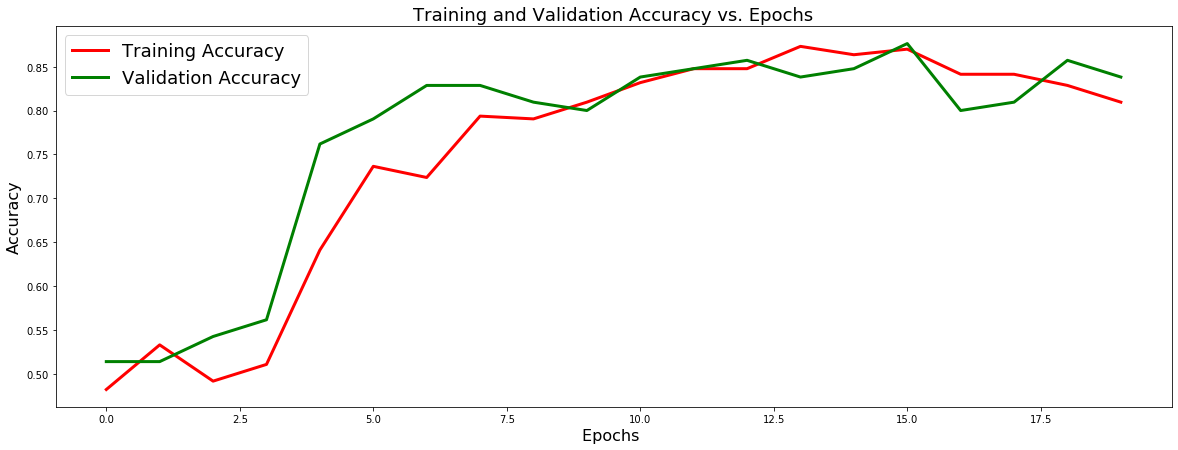

In [118]:
plt.figure(figsize=(20, 7))                                                  
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

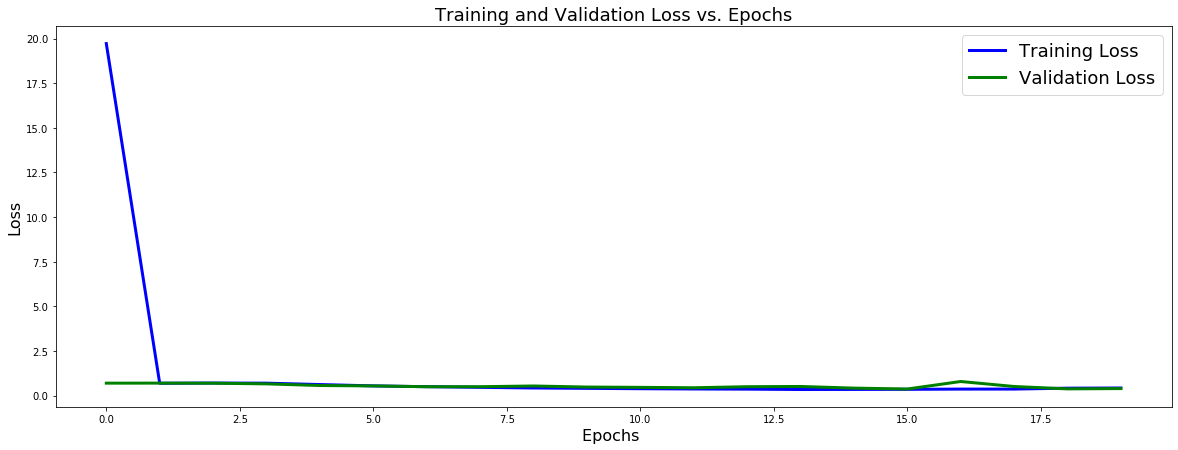

In [119]:
plt.figure(figsize=(20, 7))                                                                     
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

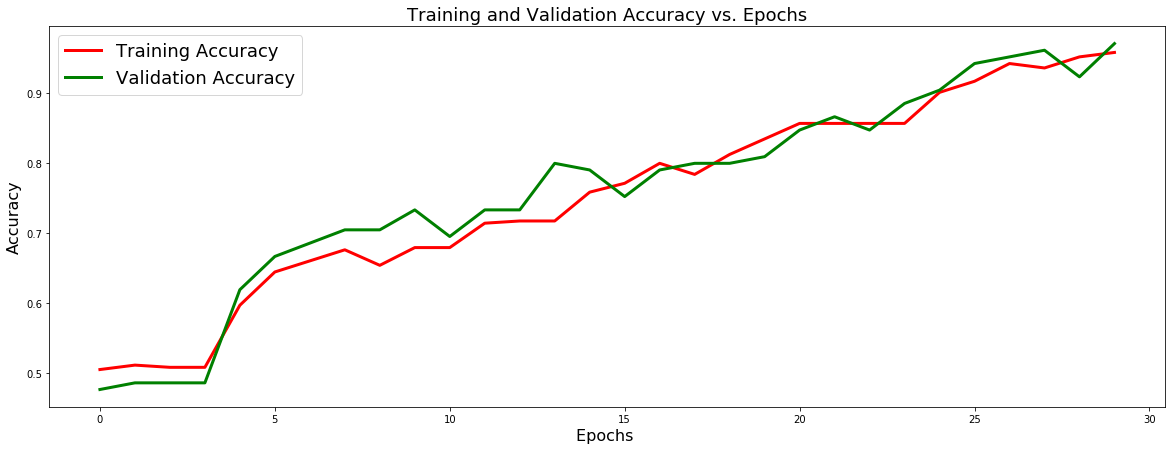

In [105]:
plt.figure(figsize=(20, 7))                                                  
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

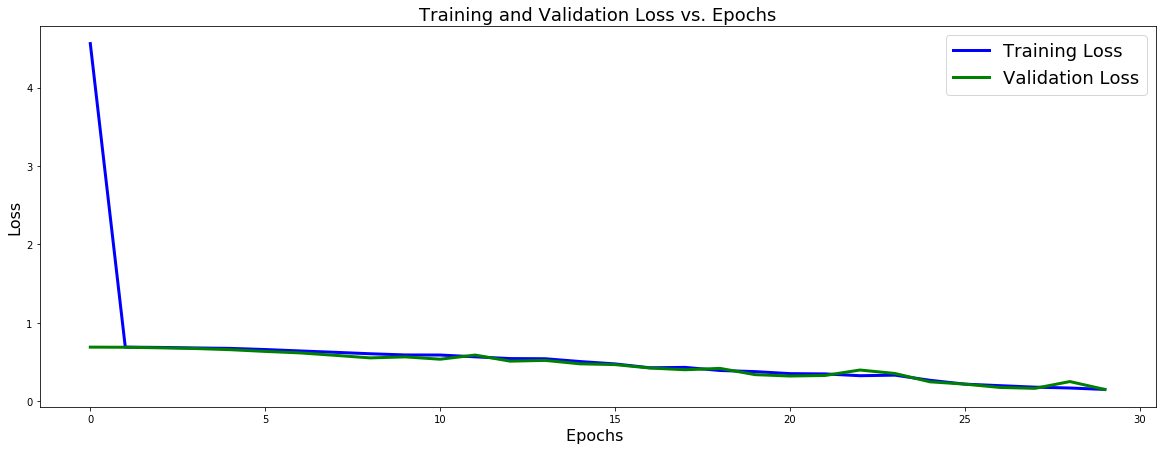

In [106]:
plt.figure(figsize=(20, 7))                                                                     
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## SGD - not as good as Adam - Tested many times with different parameters

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val), callbacks=[es, es2])

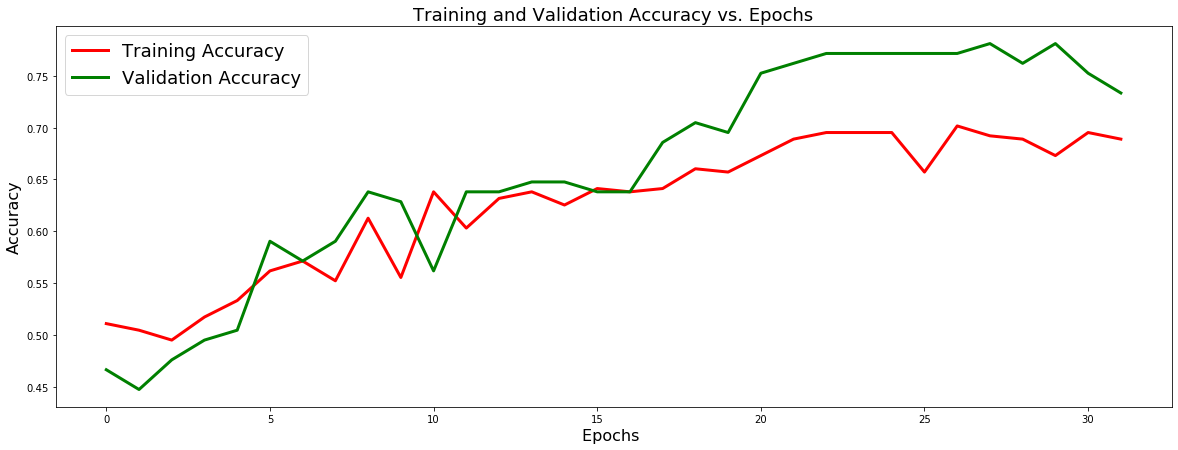

In [72]:
plt.figure(figsize=(20, 7))                                                  # lr = 0.001 momentum =0.99
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

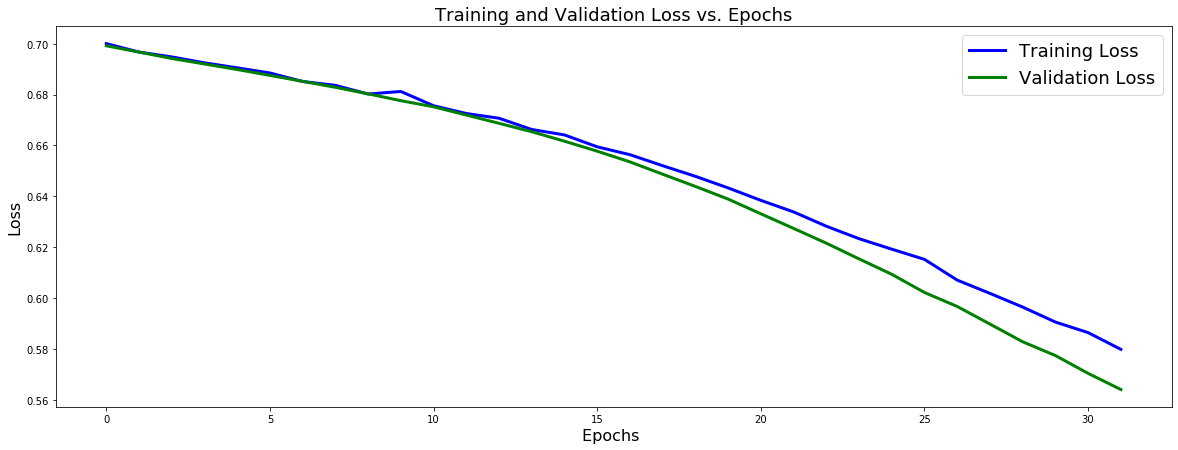

In [73]:
plt.figure(figsize=(20, 7))                                                                     # lr = 0.001 momentum =0.99 - underfitting?
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

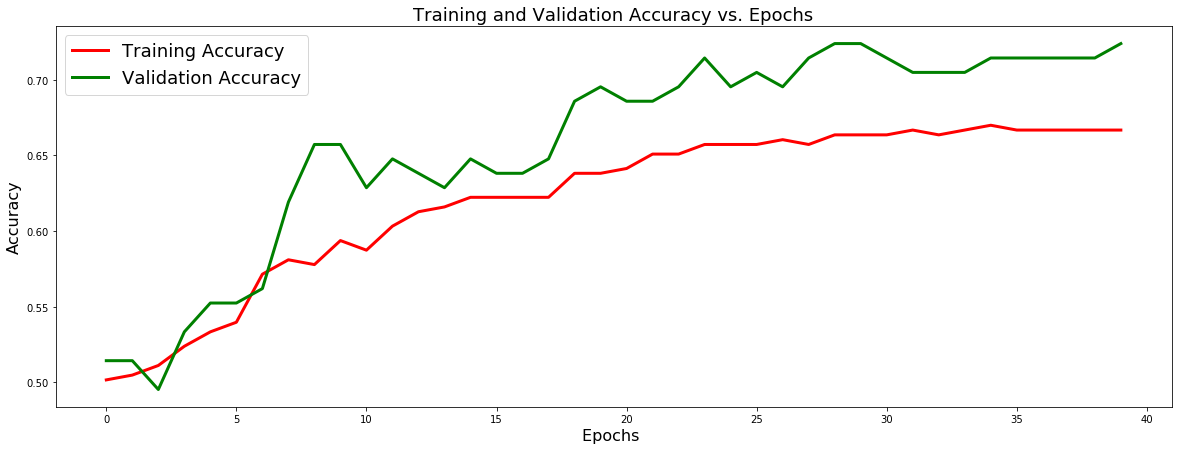

In [58]:
plt.figure(figsize=(20, 7))                                                                             # lr = 0.001 momentum =0.9
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

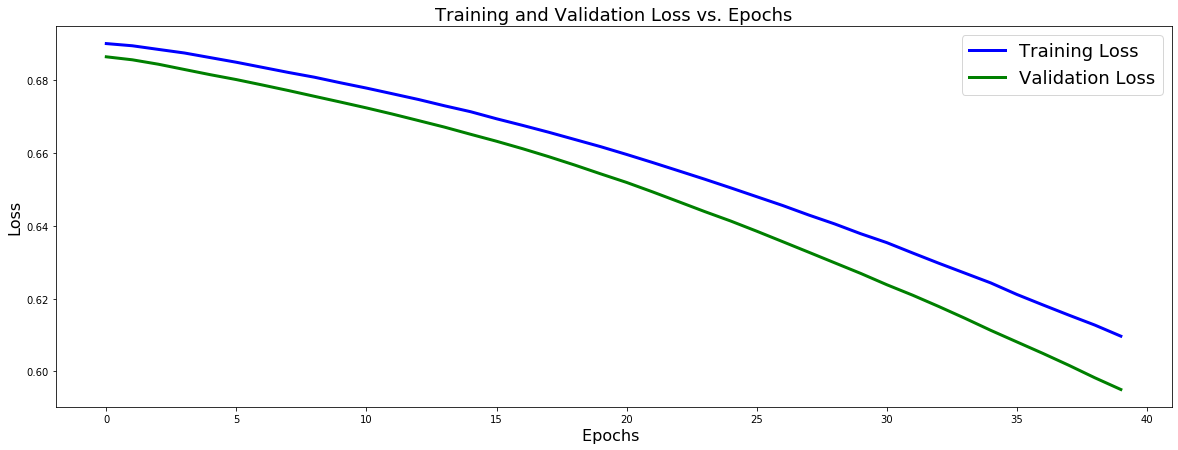

In [59]:
plt.figure(figsize=(20, 7))                                                                 # lr = 0.001 momentum =0.9 - underfitting
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

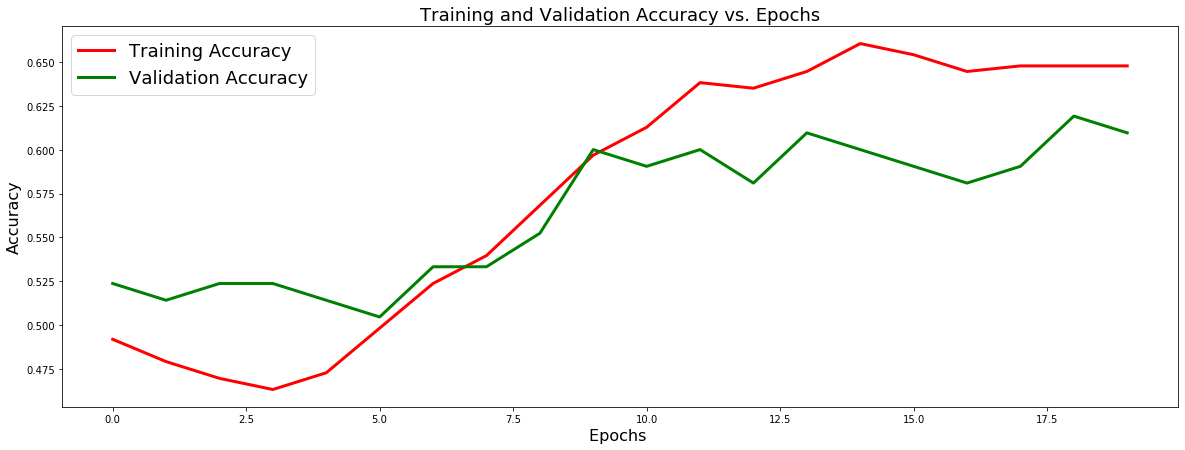

In [54]:
plt.figure(figsize=(20, 7))                                                         # lr = 0.001 momentum =0.5
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

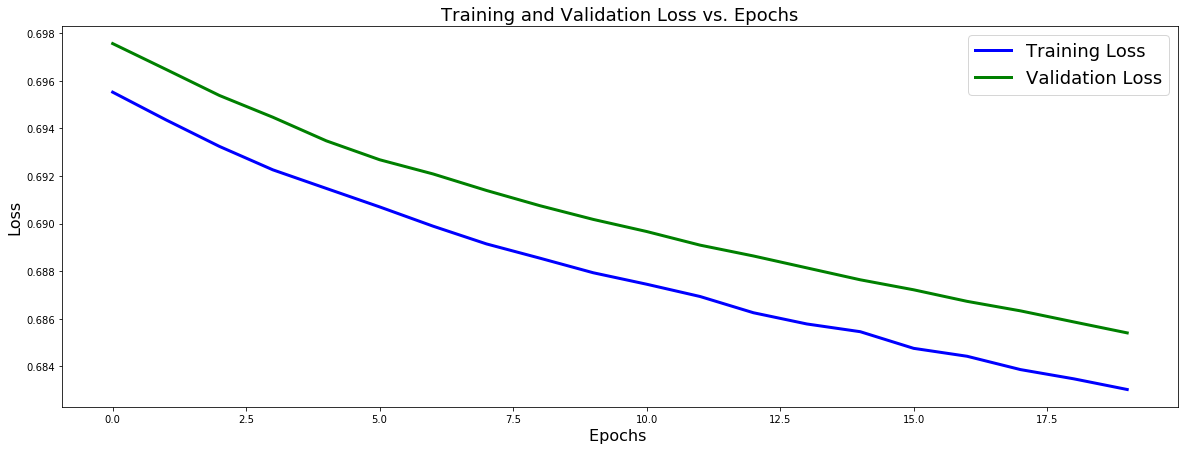

In [55]:
plt.figure(figsize=(20, 7))                                                             # lr = 0.001 momentum =0.5 - underfitting
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Evaluating on the model using Adam with LR = 0.001

In [70]:
y_pred = model.predict(x=X_test, batch_size=64)

In [71]:
y_pred = np.round(y_pred)
print(y_pred.shape)

(180, 1)


In [72]:
np.count_nonzero(y_pred == 1)

94

In [73]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]


In [74]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.98333335

In [75]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.98333333]


In [76]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred) # conf matrix may look slightly different to one in report due to trialling

Confusion matrix, without normalization
[[86  3]
 [ 0 91]]


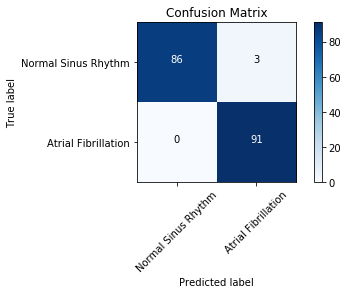

In [77]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        89
           1       0.97      1.00      0.98        91

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [ ]:
model_path = os.path.join('models', 'CNN2-Small')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Configuration 2 - ONLY WORKS WELL WITH 1 MINUTE ECG SEGMENTS - ALSO REQUIRES MORE PROCESSING POWER 

In [7]:
# Load normalised/filtered ECG training data - Use 1 min segments for this CNN
X_train, y_train = load_label_segment(train_folder, '1 min', True) 
# '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(3000, 7680, 2) (3000, 1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=30)  
#70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=30)
#75/25 train/val split 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1575, 7680, 2) (1575, 1)
(900, 7680, 2) (900, 1)
(525, 7680, 2) (525, 1)


In [46]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(7680, 2))) # Conv layer taking 1 minute segments input 7680
model.add(BatchNormalization())                                                                                                       # Adding normalisation
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=64, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.2))                                                                                                               # Dropout, prevents overfitting (20%)
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.2))                                                                                                               # Dropout (20%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.2))                                                                                                               # Dropout (20%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(Flatten())                                                                                                                  # Flatten
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))                                                           # FC Layer, 128 neurons
model.add(Dropout(0.2))                                                                                                               # Dropout (20%)
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                            # FC layer, 32 neurons
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                          # Output layer, binary classification
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 7680, 32)          352       
_________________________________________________________________
batch_normalization_7 (Batch (None, 7680, 32)          128       
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 3840, 32)          0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 3840, 32)          5152      
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 1920, 32)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 1920, 64)          10304     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 960, 64)          

## TRYING WITH SGD OPTIMIZER - Not great

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history3 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val,y_val), callbacks=[es, es2])

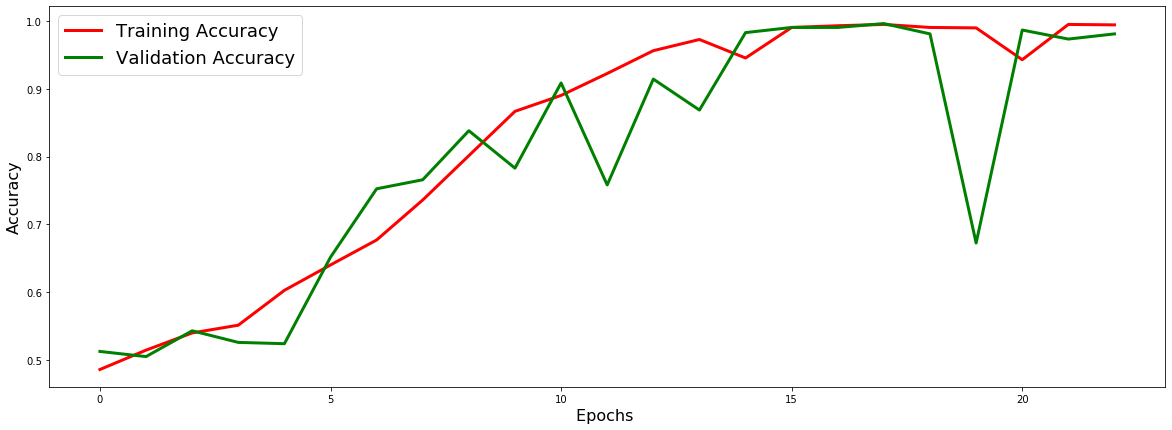

In [165]:
plt.figure(figsize=(20, 7))                                          #lr=0.001, momentum=0.9
plt.plot(history3.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

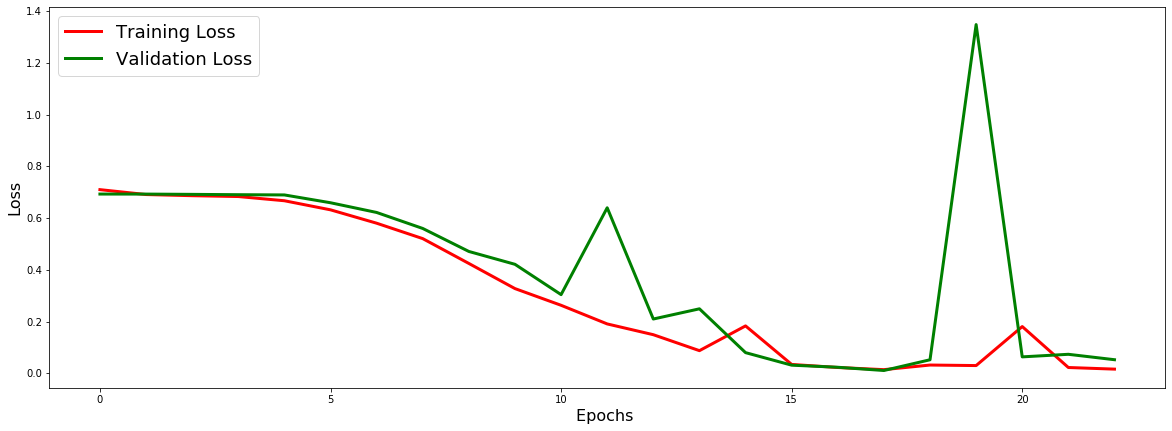

In [166]:
plt.figure(figsize=(20, 7))                                        # lr=0.001, momentum=0.9 - spikey loss
plt.plot(history3.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history3.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

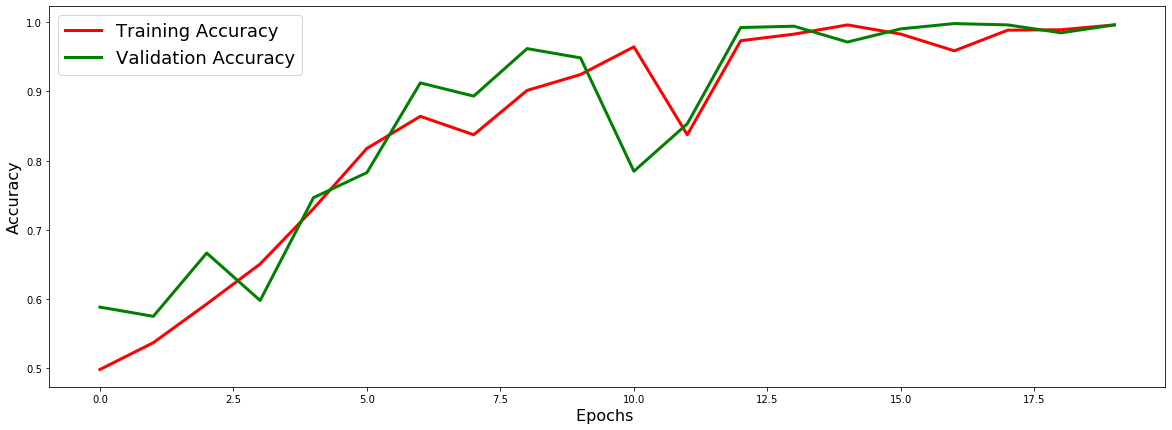

In [148]:
plt.figure(figsize=(20, 7))                                      #lr=0.001, momentum=0.9
plt.plot(history3.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

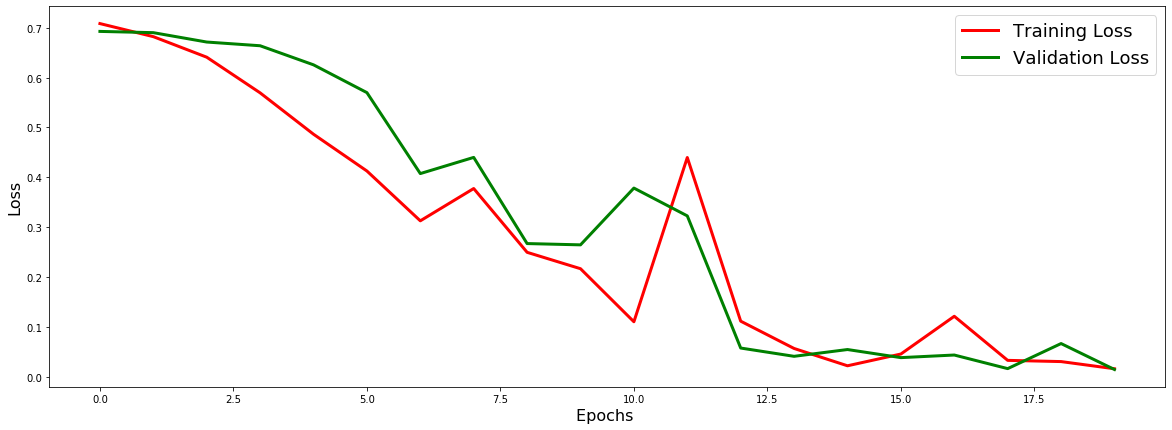

In [149]:
plt.figure(figsize=(20, 7))                                          # not very smooth
plt.plot(history3.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history3.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## TRYING ADAM - LR = 0.001 - a bit better than SGD but not great

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history4 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val,y_val), callbacks=[es, es2])

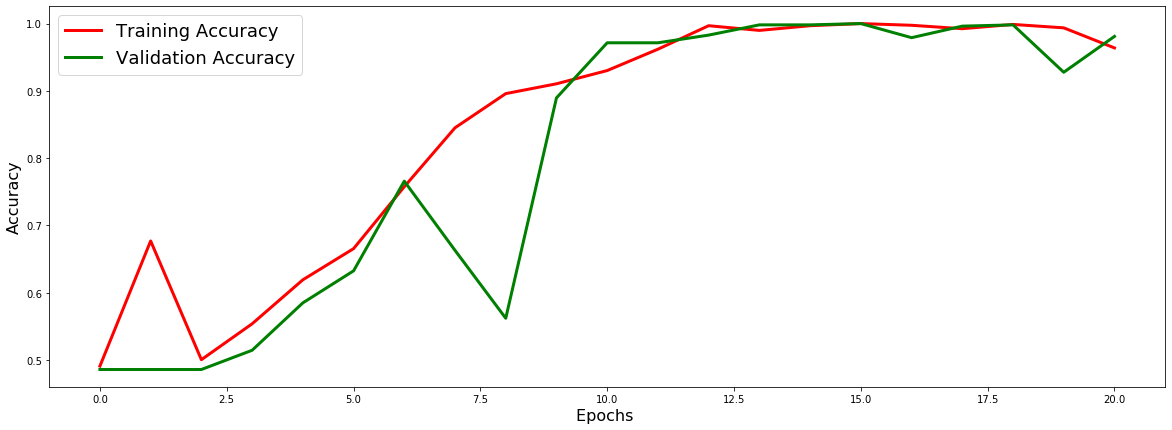

In [200]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

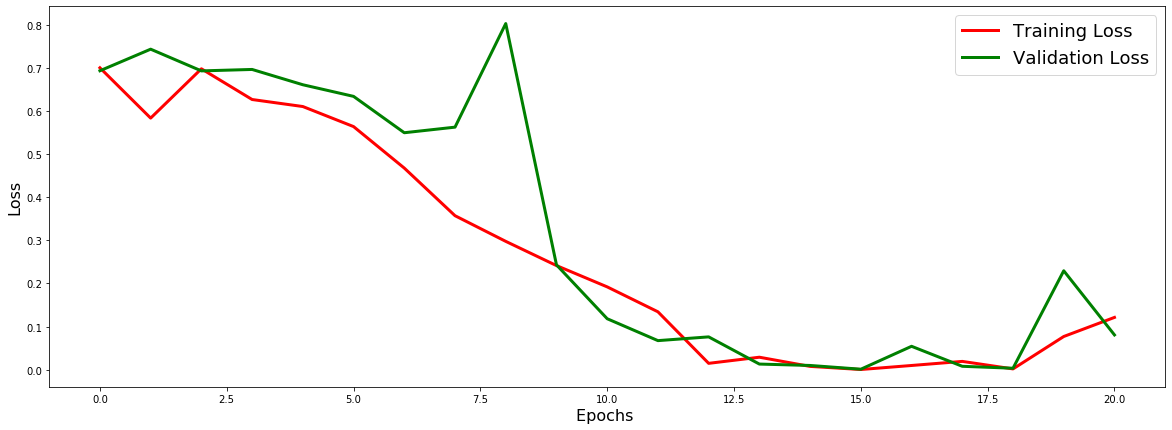

In [201]:
plt.figure(figsize=(20, 7))                                        # spikey loss but evens out
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## TRYING ADAM - LR = 0.0001 - Pretty good

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=4)
start = t.time()
history4 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val,y_val), callbacks=[es, es2])
end = t.time()
print('Time taken to run fit: ', end - start, 'seconds') # about 25 seconds

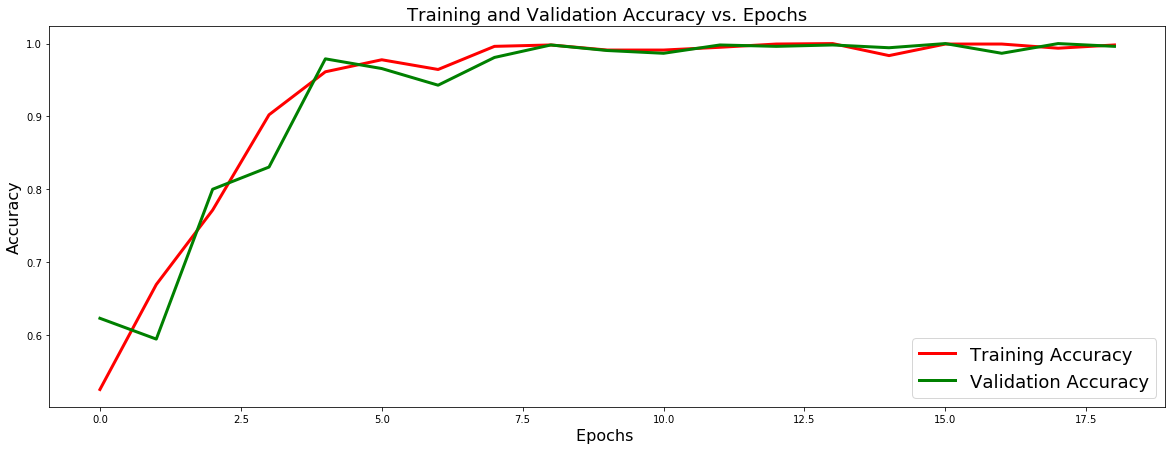

In [11]:
plt.figure(figsize=(20, 7))                                                             # fairly smooth, training should stop earlier
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

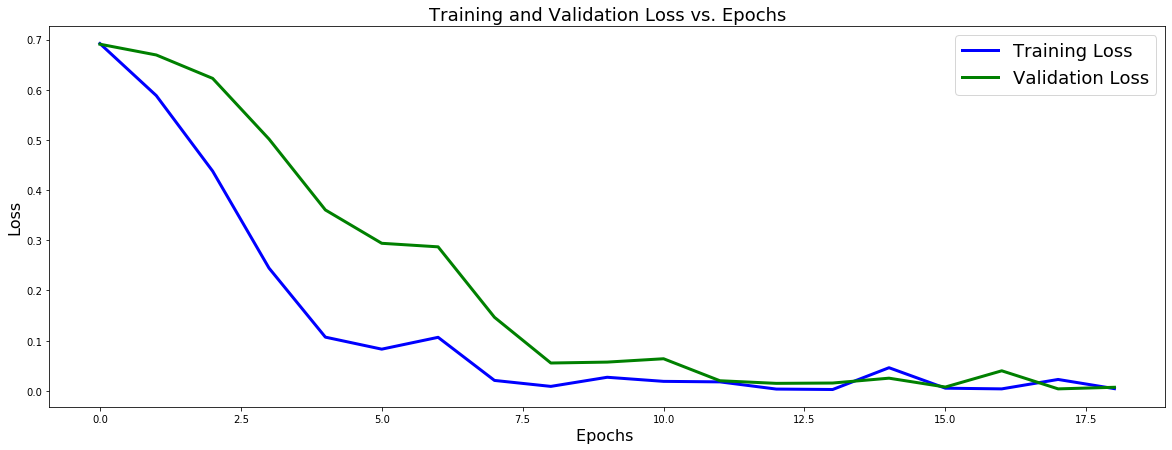

In [12]:
plt.figure(figsize=(20, 7))                                                             # decent, slightly overfitting
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

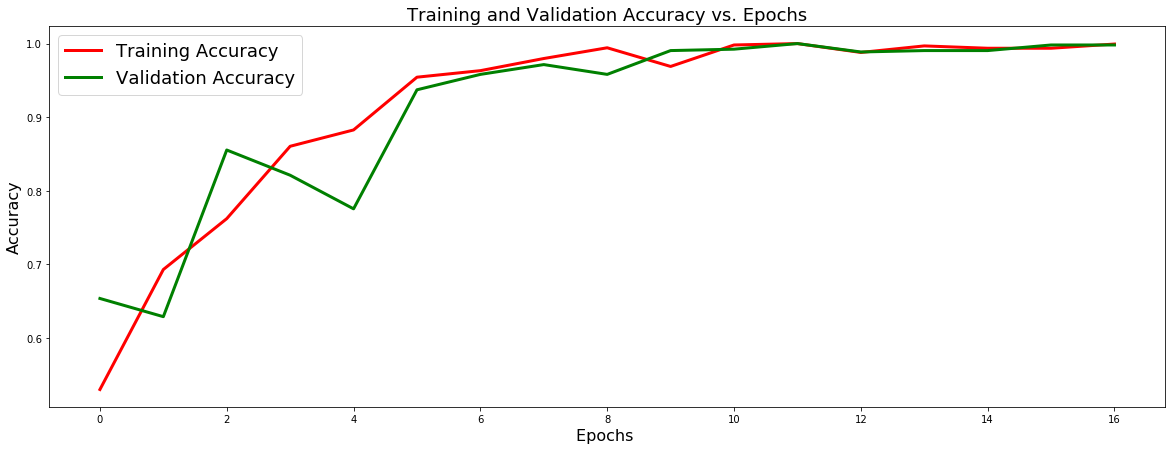

In [25]:
plt.figure(figsize=(20, 7))                                                             # quite consistent
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

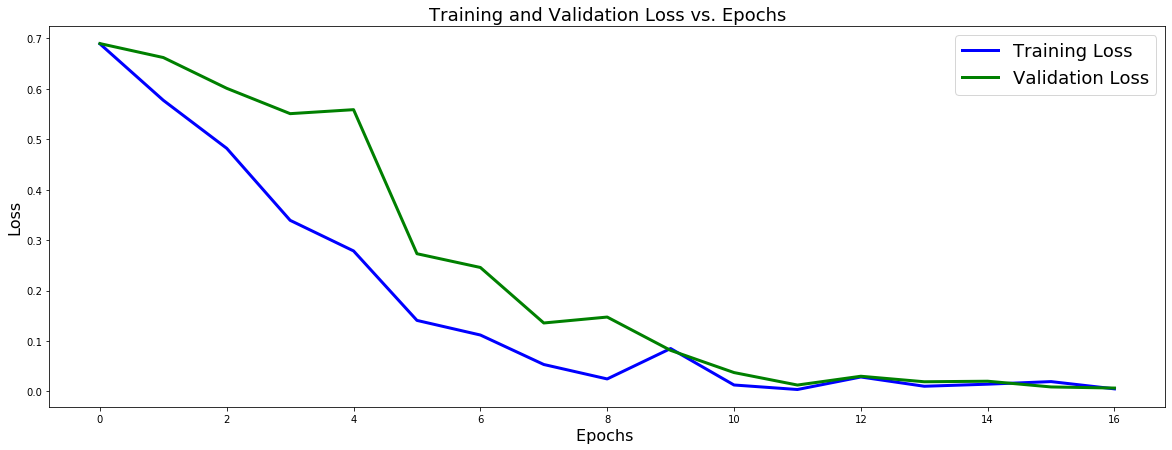

In [26]:
plt.figure(figsize=(20, 7))                                                             # fairly consistent
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

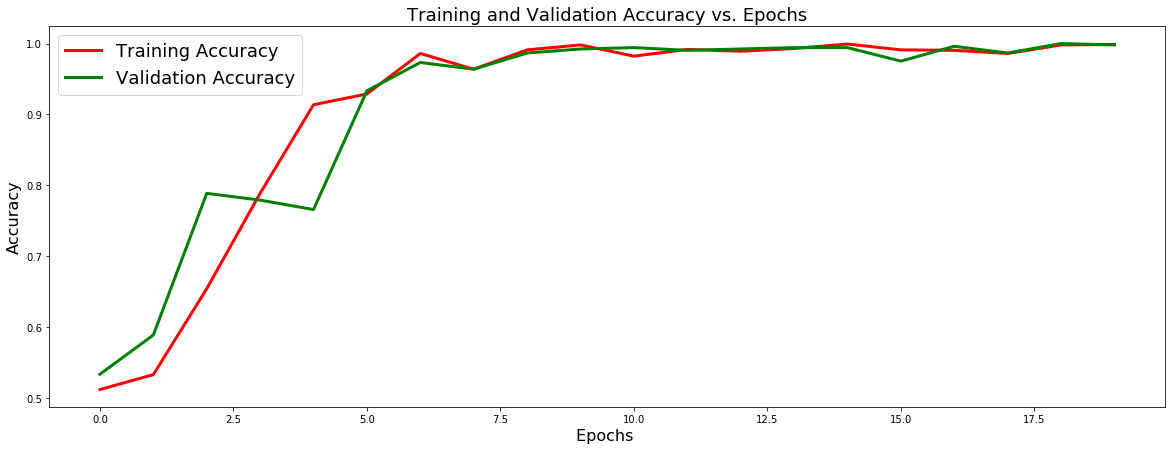

In [21]:
plt.figure(figsize=(20, 7))                                   # quite consistent
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

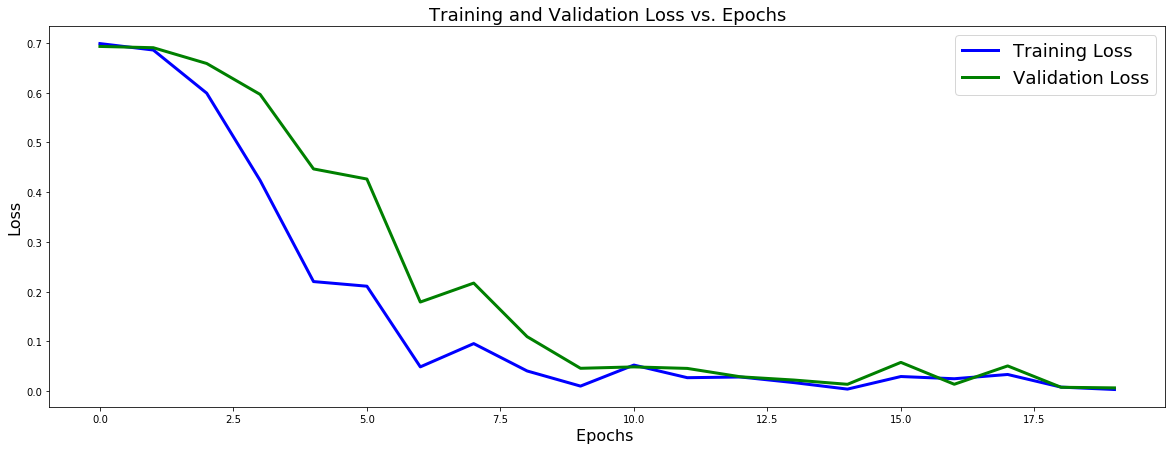

In [22]:
plt.figure(figsize=(20, 7))                                  # fairly consistent
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

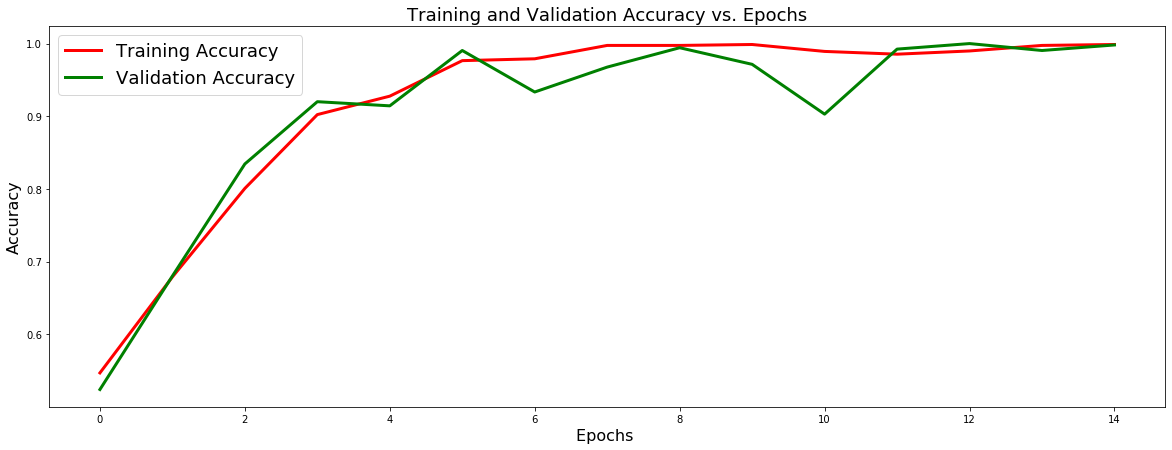

In [37]:
plt.figure(figsize=(20, 7))                                   # smooth accuracy curves here
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

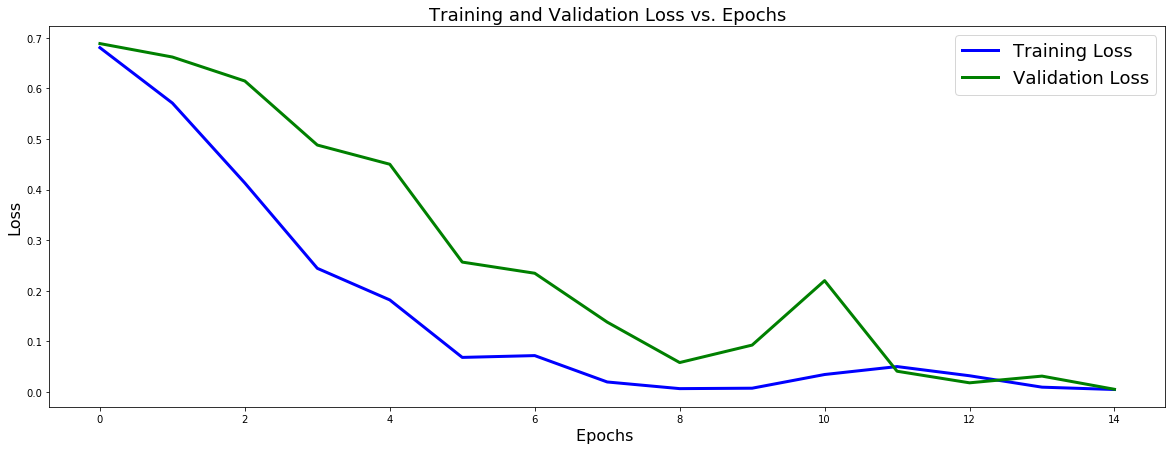

In [38]:
plt.figure(figsize=(20, 7))                                  # slight overfitting
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

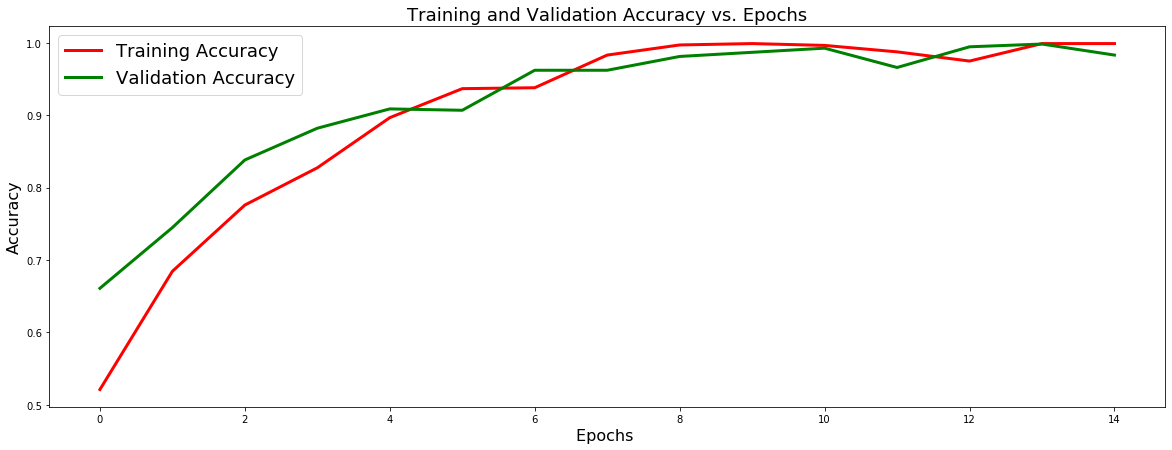

In [22]:
plt.figure(figsize=(20, 7))                                                     # smooth accuracy curve again
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

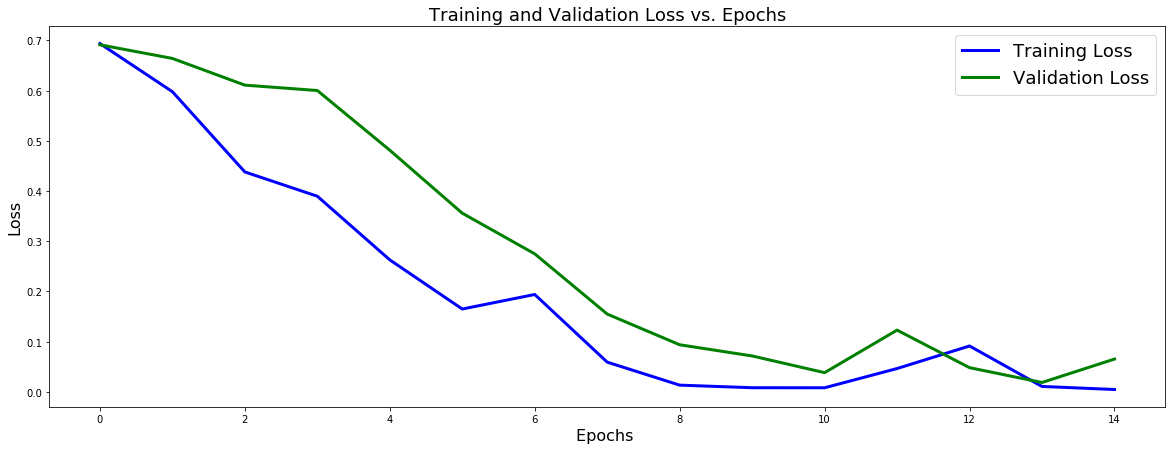

In [23]:
plt.figure(figsize=(20, 7))                                        # similar loss to above test
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

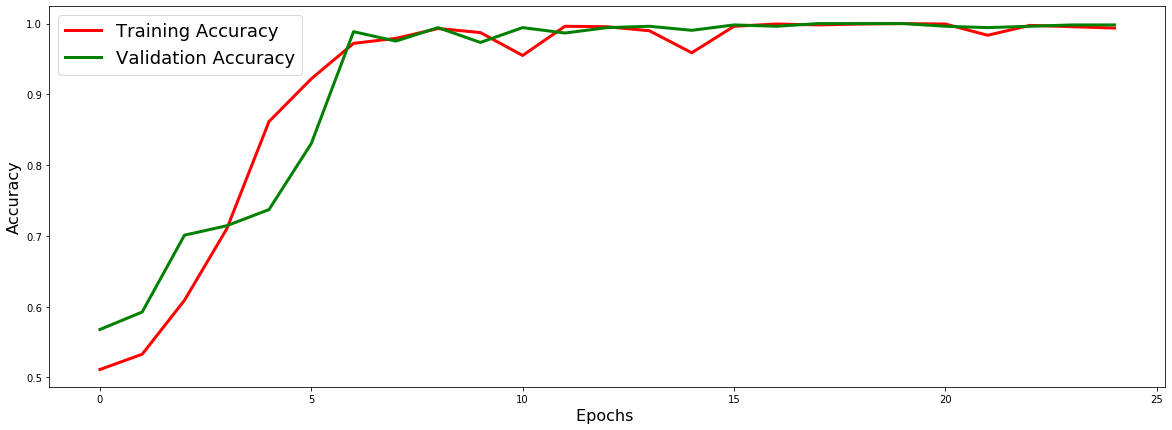

In [204]:
plt.figure(figsize=(20, 7))                     # early stopping was not implemented for this one...
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

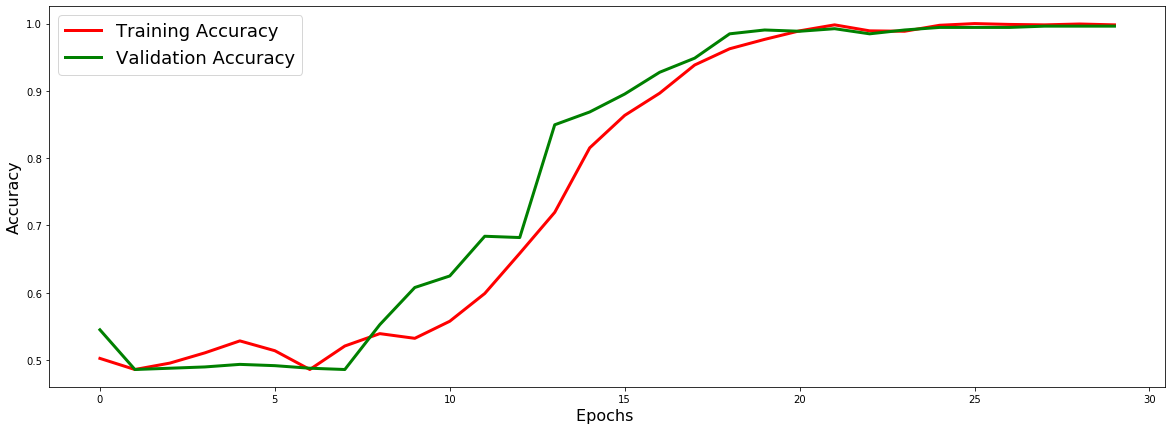

In [36]:
plt.figure(figsize=(20, 7))                                       # fairly good
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

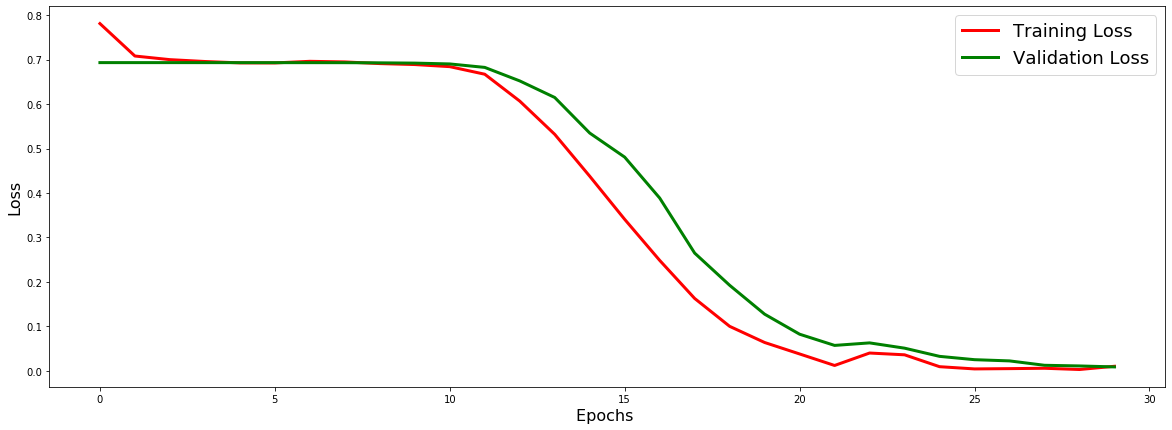

In [37]:
plt.figure(figsize=(20, 7))                             # fairly good
plt.plot(history4.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## Evaluating using Adam at LR = 0.0001 

In [48]:
y_pred = model.predict(x=X_test, batch_size=32)

In [49]:
y_pred = np.round(y_pred)

In [26]:
np.count_nonzero(y_pred == 0)

460

In [27]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]


In [28]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.99

In [29]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.99]


In [42]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred) # Conf matrix may vary slightly to the one in report due to trialling

Confusion matrix, without normalization
[[446   5]
 [ 29 420]]


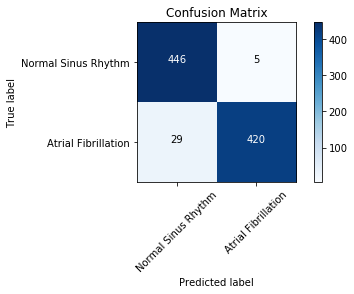

In [43]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [32]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       451
           1       1.00      0.98      0.99       449

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [34]:
model_path = os.path.join('models', 'CNN2')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

INFO:tensorflow:Assets written to: models\CNN2\assets
Saved trained model at models\CNN2 


## Extra Trees Classifier (Randomised Decision Trees) - tested using 1 minute ECG segments

In [49]:
# Load normalised/filtered ECG training data - Use 1 min segments for Decision Trees
X_train, y_train = load_label_segment(train_folder, '1 min', True) 
print(X_train.shape, y_train.shape)

(3000, 7680, 2) (3000, 1)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=30)

In [51]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400, 7680, 2) (2400, 1)
(600, 7680, 2) (600, 1)


In [52]:
n_samples_train, n_x_train, n_y_train = X_train.shape

In [53]:
X_train_2D = X_train.reshape((n_samples_train,n_x_train*n_y_train))  
# reshape to 1D
print(X_train_2D.shape)

(2400, 15360)


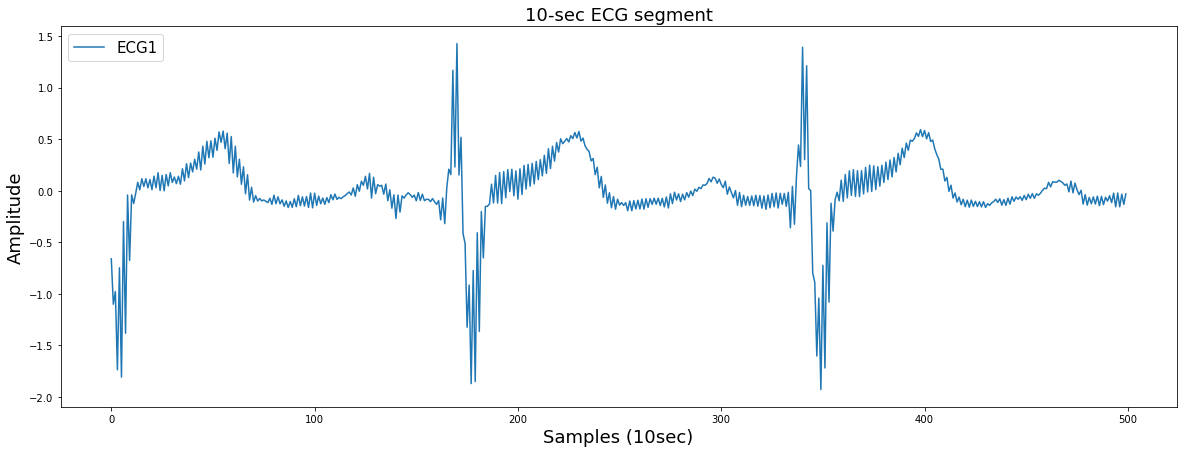

In [85]:
plt.figure(figsize=(20, 7))
plt.plot(X_train_2D[1][1000:1500])  
plt.xlabel('Samples (10sec)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
plt.show()

In [68]:
extratree = ExtraTreesClassifier(n_estimators=1000, criterion='gini', random_state=30)

In [69]:
start = t.time()
extratree.fit(X_train_2D, y_train)
end = t.time()
print('Time taken to run Extra Trees fit: ', end - start, 'seconds') # about 90 seconds

Time taken to run Extra Trees fit:  93.6543447971344 seconds


In [56]:
n_samples_test, n_x_test, n_y_test = X_test.shape

In [57]:
X_test_2D = X_test.reshape(( n_samples_test, n_x_test*n_y_test ))

In [58]:
print(X_test_2D.shape)

(600, 15360)


In [59]:
y_test[3]

array([1])

In [60]:
y_pred_extra_tree = extratree.predict(X_test_2D)

In [61]:
acc_extra_tree = extratree.score(X_test_2D, y_test)
print(acc_extra_tree)

0.7816666666666666


In [62]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_extra_tree)

Confusion matrix, without normalization
[[246  63]
 [ 68 223]]


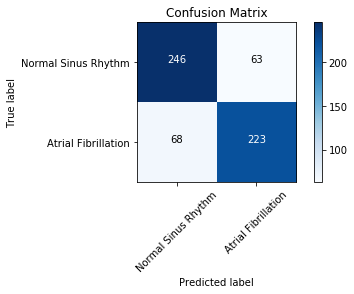

In [63]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [64]:
print(classification_report(y_true=y_test, y_pred=y_pred_extra_tree))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       309
           1       0.78      0.77      0.77       291

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



In [65]:
average_precision = average_precision_score(y_test, y_pred_extra_tree)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.71')

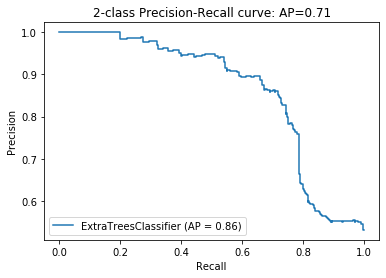

In [66]:
disp = plot_precision_recall_curve(extratree, X_test_2D, y_test)    # precision recall curve was used but was ommitted from report
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))